In [1]:
from glob import glob
from pympi import Elan
import os
import pandas as pd
import enchant
from pydub import AudioSegment

# Make csv with EAF annotations

In [66]:
eaf_raw_path='../data/tira-asr/eaf_raw.csv'
df = pd.read_csv(eaf_raw_path, keep_default_na=False)
df.head()


,start,end,transcription,eaf_source,wav_source
0,184240,189330,mə̀nà tʃàt̪á án âjt̪ɔ́ ŋìðə̀nɔ́ŋ ŋírɔ́t...,/Users/markjos/Library/CloudStorage/GoogleDriv...,/G:/Shared drives/Tira/Recordings/2022-07-19-T...
1,244720,245840,mna tʃat̪a,/Users/markjos/Library/CloudStorage/GoogleDriv...,/G:/Shared drives/Tira/Recordings/2022-07-19-T...
2,247990,249050,an ajt̪ɔ,/Users/markjos/Library/CloudStorage/GoogleDriv...,/G:/Shared drives/Tira/Recordings/2022-07-19-T...
3,257670,258760,an ajit̪ɔ ŋiðinɔŋ,/Users/markjos/Library/CloudStorage/GoogleDriv...,/G:/Shared drives/Tira/Recordings/2022-07-19-T...
4,260180,261110,ŋirɔt̪ɛ,/Users/markjos/Library/CloudStorage/GoogleDriv...,/G:/Shared drives/Tira/Recordings/2022-07-19-T...


# Normalize diacs and remove toneless entries

In [67]:
import unicodedata

In [68]:
df['unicode_norm'] = df['transcription'].apply(lambda s: unicodedata.normalize('NFKD', s))
df.head()

,start,end,transcription,eaf_source,wav_source,unicode_norm
0,184240,189330,mə̀nà tʃàt̪á án âjt̪ɔ́ ŋìðə̀nɔ́ŋ ŋírɔ́t...,/Users/markjos/Library/CloudStorage/GoogleDriv...,/G:/Shared drives/Tira/Recordings/2022-07-19-T...,mə̀nà tʃàt̪á án âjt̪ɔ́ ŋìðə̀nɔ́ŋ ŋírɔ́t...
1,244720,245840,mna tʃat̪a,/Users/markjos/Library/CloudStorage/GoogleDriv...,/G:/Shared drives/Tira/Recordings/2022-07-19-T...,mna tʃat̪a
2,247990,249050,an ajt̪ɔ,/Users/markjos/Library/CloudStorage/GoogleDriv...,/G:/Shared drives/Tira/Recordings/2022-07-19-T...,an ajt̪ɔ
3,257670,258760,an ajit̪ɔ ŋiðinɔŋ,/Users/markjos/Library/CloudStorage/GoogleDriv...,/G:/Shared drives/Tira/Recordings/2022-07-19-T...,an ajit̪ɔ ŋiðinɔŋ
4,260180,261110,ŋirɔt̪ɛ,/Users/markjos/Library/CloudStorage/GoogleDriv...,/G:/Shared drives/Tira/Recordings/2022-07-19-T...,ŋirɔt̪ɛ


In [69]:
tone_markers = {
    'grave': "\u0300",
    'macrn': "\u0304",
    'acute': "\u0301",
    'circm': "\u0302",
    'caron': "\u030C",
}
has_tone = lambda s: any(diac in s for diac in tone_markers.values())

print(len(df))
df_tone=df.copy()[df['unicode_norm'].apply(has_tone)]
len(df_tone)

28820


26697

# Remove punctuation

In [70]:
from string import punctuation

In [71]:
has_punct = lambda s: any(c in punctuation for c in s)
def punct_to_space(s):
    for c in punctuation:
        s=s.replace(c, ' ')
    return s
normalize_spaces = lambda s: ' '.join(s.split())
remove_punct = lambda s: normalize_spaces(punct_to_space(s))
has_punct('hello!?'), remove_punct('h?ell:;,.o?!&')

(True, 'h ell o')

In [72]:
df_tone.loc[df_tone['unicode_norm'].apply(has_punct), 'unicode_norm']

0        mə̀nà tʃàt̪á án âjt̪ɔ́ ŋìðə̀nɔ́ŋ ŋírɔ́t...
15       mnà tʃàt̪á án ájít̪ɔ́ ŋìðìnɔ́ŋ ŋ̀rɔ́t̪...
16       án âjt̪ɔ́ ŋíðə̀nɔ́ŋ ŋʊ̀rɔ́t̪ɛ̌, íŋgáŋâɽi...
18       án âjt̪ɔ́ ŋíðə̀nɔ́ŋ ŋʊ̀rɔ́t̪ɛ̌, íŋgáŋâɽi...
20       án âjt̪ɔ́ ŋíðə̀nɔ́ŋ ŋʊ̀rɔ́t̪ɛ̌, íŋgáŋâɽi...
                               ...                        
28719    kúkù kâŋtɔ́ kɔ́rìŋú nɛ̀ lɛ̀vɛ̀r dɛ̀, àn ...
28720    kúkù kâŋtɔ́ kɔ́rìŋú nɛ̀ lɛ̀vɛ̀r dɛ̀, àn ...
28724                           jɛ́ûrmùðɔ̀, jɛ́ûrmùðɔ̀
28739                       ùrɔ̀...ùrnɔ̀ kàrɔ́ t̪àŋòŋ
28755    ùrnɔ̀ kàrɔ́ t̪á àprí jàŋó...àprí jɛ́u...
Name: unicode_norm, Length: 1273, dtype: object

In [73]:
df_tone['no_punct'] = df_tone['unicode_norm'].apply(remove_punct)
df_tone.head()

,start,end,transcription,eaf_source,wav_source,unicode_norm,no_punct
0,184240,189330,mə̀nà tʃàt̪á án âjt̪ɔ́ ŋìðə̀nɔ́ŋ ŋírɔ́t...,/Users/markjos/Library/CloudStorage/GoogleDriv...,/G:/Shared drives/Tira/Recordings/2022-07-19-T...,mə̀nà tʃàt̪á án âjt̪ɔ́ ŋìðə̀nɔ́ŋ ŋírɔ́t...,mə̀nà tʃàt̪á án âjt̪ɔ́ ŋìðə̀nɔ́ŋ ŋírɔ́t...
7,271280,272310,íŋgáŋâɽìɲǎ,/Users/markjos/Library/CloudStorage/GoogleDriv...,/G:/Shared drives/Tira/Recordings/2022-07-19-T...,íŋgáŋâɽìɲǎ,íŋgáŋâɽìɲǎ
8,275030,276050,íŋgáŋâɽìɲǎ,/Users/markjos/Library/CloudStorage/GoogleDriv...,/G:/Shared drives/Tira/Recordings/2022-07-19-T...,íŋgáŋâɽìɲǎ,íŋgáŋâɽìɲǎ
9,304295,305015,íŋgáŋâɽìɲǎ,/Users/markjos/Library/CloudStorage/GoogleDriv...,/G:/Shared drives/Tira/Recordings/2022-07-19-T...,íŋgáŋâɽìɲǎ,íŋgáŋâɽìɲǎ
10,331510,333800,ŋìðə̀ní ŋrɔ̀t̪ɔ́ t̪ɔ́wə̀nì,/Users/markjos/Library/CloudStorage/GoogleDriv...,/G:/Shared drives/Tira/Recordings/2022-07-19-T...,ŋìðə̀ní ŋrɔ̀t̪ɔ́ t̪ɔ́wə̀nì,ŋìðə̀ní ŋrɔ̀t̪ɔ́ t̪ɔ́wə̀nì


# Detect rows with English

In [74]:
en_dict = enchant.request_dict('en_US')
en_dict

In [75]:
is_en_word = lambda w: en_dict.check(w) and (not has_tone(w)) and len(w)!=1

In [76]:
has_english = lambda s: any(is_en_word(w) for w in s.split())
en_rows = df_tone['no_punct'].apply(has_english)
en_rows.value_counts()


no_punct
False    26497
True       200
Name: count, dtype: int64

In [77]:
get_english_words = lambda s: ', '.join(word for word in s.split() if is_en_word(word))
get_english_words('yeah apri jicelo')

'yeah'

In [78]:
df_tone['en_words']=df_tone['no_punct'].apply(get_english_words)
df_tone[en_rows][['no_punct', 'en_words']].head()

,no_punct,en_words
709,you can say ŋɛ́n ŋɔ̂ɽàt̪à nɛ̀ lə̀vɛ̌r,"you, can, say"
710,yeah ŋɛ́n ŋɔ̂ɽàt̪à nɛ̀ lə̀vɛ̌r,yeah
722,so you can say ŋɛ́n ŋɔ́ɽít̪ɔ̀ àpɾíɲà,"so, you, can, say"
915,or àvàlà àvàlà kèclò,or
1001,Canada gônór USA,"Canada, USA"


In [79]:
en_df_path = '../data/tira-asr/has_english.csv'
df_tone[en_rows].to_csv(en_df_path, index=False)

In [80]:
df_noeng = df_tone.copy()[~en_rows]
df_noeng.shape

(26497, 8)

# Detect upper case chars

In [81]:
is_tone_word = lambda s: all(c in 'HML' for c in s)
has_tone_word = lambda s: any(is_tone_word(w) for w in s.split())
remove_tone_word = lambda s: ' '.join(word for word in s.split() if not is_tone_word(word))
df_noeng['no_tone_word']=df_noeng['no_punct'].apply(remove_tone_word)
df_noeng[df_noeng['no_punct'].apply(has_tone_word)]

,start,end,transcription,eaf_source,wav_source,unicode_norm,no_punct,en_words,no_tone_word
748,154895,156955,kə̀və̀lɛ̀ðátɛ́ únɛ̀ɾɛ̀ LLHH HLHL,/Users/markjos/Library/CloudStorage/GoogleDriv...,/Users/ninahk/Library/CloudStorage/GoogleDrive...,kə̀və̀lɛ̀ðátɛ́ únɛ̀ɾɛ̀ LLHH HLHL,kə̀və̀lɛ̀ðátɛ́ únɛ̀ɾɛ̀ LLHH HLHL,,kə̀və̀lɛ̀ðátɛ́ únɛ̀ɾɛ̀
750,174570,176780,jɪ́və̀lɛ̀ðátɛ́ únɛ̀ɾɛ̀ HLHH HLHL,/Users/markjos/Library/CloudStorage/GoogleDriv...,/Users/ninahk/Library/CloudStorage/GoogleDrive...,jɪ́və̀lɛ̀ðátɛ́ únɛ̀ɾɛ̀ HLHH HLHL,jɪ́və̀lɛ̀ðátɛ́ únɛ̀ɾɛ̀ HLHH HLHL,,jɪ́və̀lɛ̀ðátɛ́ únɛ̀ɾɛ̀
777,678605,681168,īŋgáŋávə̀lɛ̀ðà ǹdàbàgɛ̀ H-HL-L L-L-L L-L,/Users/markjos/Library/CloudStorage/GoogleDriv...,/Users/ninahk/Library/CloudStorage/GoogleDrive...,īŋgáŋávə̀lɛ̀ðà ǹdàbàgɛ̀ H-HL-L L-L-L L-L,īŋgáŋávə̀lɛ̀ðà ǹdàbàgɛ̀ H HL L L L L L L,,īŋgáŋávə̀lɛ̀ðà ǹdàbàgɛ̀
2596,726520,732460,lǎllǔvə́lɛ̂ːðǎ ... ndɔ̀bàɡɛ̌ ... LH LH H H...,/Users/markjos/Library/CloudStorage/GoogleDriv...,/Volumes/GoogleDrive/Shared drives/Tira/Record...,lǎllǔvə́lɛ̂ːðǎ ... ndɔ̀bàɡɛ̌ ... LH LH H H...,lǎllǔvə́lɛ̂ːðǎ ndɔ̀bàɡɛ̌ LH LH H HL LLL,,lǎllǔvə́lɛ̂ːðǎ ndɔ̀bàɡɛ̌
19006,771225,774634,ùrnàŋgéi kə̀və̀lɛ̀ðɔ́ ðáŋàlà LLH LLH HLL,/Users/markjos/Library/CloudStorage/GoogleDriv...,/Volumes/GoogleDrive/Shared drives/Tira/Record...,ùrnàŋgéi kə̀və̀lɛ̀ðɔ́ ðáŋàlà LLH LLH HLL,ùrnàŋgéi kə̀və̀lɛ̀ðɔ́ ðáŋàlà LLH LLH HLL,,ùrnàŋgéi kə̀və̀lɛ̀ðɔ́ ðáŋàlà
19016,975220,978020,jɛ́vəlɛ̀ðáŋà ùnɛ̀rɛ̀ HLLHL HLH,/Users/markjos/Library/CloudStorage/GoogleDriv...,/Volumes/GoogleDrive/Shared drives/Tira/Record...,jɛ́vəlɛ̀ðáŋà ùnɛ̀rɛ̀ HLLHL HLH,jɛ́vəlɛ̀ðáŋà ùnɛ̀rɛ̀ HLLHL HLH,,jɛ́vəlɛ̀ðáŋà ùnɛ̀rɛ̀
19021,1035723,1038078,kə̀və̀lɛ̀ðɛ́ŋí únɛ̀rɛ̀ LLLHH HLHL,/Users/markjos/Library/CloudStorage/GoogleDriv...,/Volumes/GoogleDrive/Shared drives/Tira/Record...,kə̀və̀lɛ̀ðɛ́ŋí únɛ̀rɛ̀ LLLHH HLHL,kə̀və̀lɛ̀ðɛ́ŋí únɛ̀rɛ̀ LLLHH HLHL,,kə̀və̀lɛ̀ðɛ́ŋí únɛ̀rɛ̀
19032,1172967,1175594,kə̀və̀lɛ̀ðáŋá ûnɛ̀rɛ̀ LLLHH HLHL,/Users/markjos/Library/CloudStorage/GoogleDriv...,/Volumes/GoogleDrive/Shared drives/Tira/Record...,kə̀və̀lɛ̀ðáŋá ûnɛ̀rɛ̀ LLLHH HLHL,kə̀və̀lɛ̀ðáŋá ûnɛ̀rɛ̀ LLLHH HLHL,,kə̀və̀lɛ̀ðáŋá ûnɛ̀rɛ̀
19045,1456032,1458595,ɲàvə̀lɛ̀ðáŋà ùnɛ̀rɛ̀ LLLHL LHL,/Users/markjos/Library/CloudStorage/GoogleDriv...,/Volumes/GoogleDrive/Shared drives/Tira/Record...,ɲàvə̀lɛ̀ðáŋà ùnɛ̀rɛ̀ LLLHL LHL,ɲàvə̀lɛ̀ðáŋà ùnɛ̀rɛ̀ LLLHL LHL,,ɲàvə̀lɛ̀ðáŋà ùnɛ̀rɛ̀
19052,1680477,1682643,kə̀və̀lɛ̀ðálír ùnɛ̀rɛ̀ LLLHH HLHL,/Users/markjos/Library/CloudStorage/GoogleDriv...,/Volumes/GoogleDrive/Shared drives/Tira/Record...,kə̀və̀lɛ̀ðálír ùnɛ̀rɛ̀ LLLHH HLHL,kə̀və̀lɛ̀ðálír ùnɛ̀rɛ̀ LLLHH HLHL,,kə̀və̀lɛ̀ðálír ùnɛ̀rɛ̀


In [82]:
has_upper = lambda s: s.lower()!=s
df_noeng[df_noeng['no_tone_word'].apply(has_upper)]

,start,end,transcription,eaf_source,wav_source,unicode_norm,no_punct,en_words,no_tone_word
4634,350380,352030,lɜ̀ù lɛjja ed̪ɔɽɔlɛDEL,/Users/markjos/Library/CloudStorage/GoogleDriv...,/G:/Shared drives/Tira/Recordings/2021-08-04-T...,lɜ̀ù lɛjja ed̪ɔɽɔlɛDEL,lɜ̀ù lɛjja ed̪ɔɽɔlɛDEL,,lɜ̀ù lɛjja ed̪ɔɽɔlɛDEL
18271,1464502,1465190,Ídɜ́ɽí,/Users/markjos/Library/CloudStorage/GoogleDriv...,/Volumes/GoogleDrive/Shared drives/Tira/Record...,Ídɜ́ɽí,Ídɜ́ɽí,,Ídɜ́ɽí
18272,1476594,1478117,Ídɜ́ɽí kɪ̀cə̀ló,/Users/markjos/Library/CloudStorage/GoogleDriv...,/Volumes/GoogleDrive/Shared drives/Tira/Record...,Ídɜ́ɽí kɪ̀cə̀ló,Ídɜ́ɽí kɪ̀cə̀ló,,Ídɜ́ɽí kɪ̀cə̀ló
18273,1480070,1481374,Ídɜ́ɽí kɪ̀cə̀ló,/Users/markjos/Library/CloudStorage/GoogleDriv...,/Volumes/GoogleDrive/Shared drives/Tira/Record...,Ídɜ́ɽí kɪ̀cə̀ló,Ídɜ́ɽí kɪ̀cə̀ló,,Ídɜ́ɽí kɪ̀cə̀ló
18274,1484275,1485621,Ídɜ́ɽí kɪ̀cə̀ló,/Users/markjos/Library/CloudStorage/GoogleDriv...,/Volumes/GoogleDrive/Shared drives/Tira/Record...,Ídɜ́ɽí kɪ̀cə̀ló,Ídɜ́ɽí kɪ̀cə̀ló,,Ídɜ́ɽí kɪ̀cə̀ló
18275,1490844,1492101,Ídɜ́ɽí kɪ̀cə̀ló,/Users/markjos/Library/CloudStorage/GoogleDriv...,/Volumes/GoogleDrive/Shared drives/Tira/Record...,Ídɜ́ɽí kɪ̀cə̀ló,Ídɜ́ɽí kɪ̀cə̀ló,,Ídɜ́ɽí kɪ̀cə̀ló
18464,1464502,1465190,Ídɜ́ɽí,/Users/markjos/Library/CloudStorage/GoogleDriv...,/Volumes/GoogleDrive/Shared drives/Tira/Record...,Ídɜ́ɽí,Ídɜ́ɽí,,Ídɜ́ɽí
18465,1476594,1478117,Ídɜ́ɽí kɪ̀cə̀ló,/Users/markjos/Library/CloudStorage/GoogleDriv...,/Volumes/GoogleDrive/Shared drives/Tira/Record...,Ídɜ́ɽí kɪ̀cə̀ló,Ídɜ́ɽí kɪ̀cə̀ló,,Ídɜ́ɽí kɪ̀cə̀ló
18466,1480070,1481374,Ídɜ́ɽí kɪ̀cə̀ló,/Users/markjos/Library/CloudStorage/GoogleDriv...,/Volumes/GoogleDrive/Shared drives/Tira/Record...,Ídɜ́ɽí kɪ̀cə̀ló,Ídɜ́ɽí kɪ̀cə̀ló,,Ídɜ́ɽí kɪ̀cə̀ló
18467,1484275,1485621,Ídɜ́ɽí kɪ̀cə̀ló,/Users/markjos/Library/CloudStorage/GoogleDriv...,/Volumes/GoogleDrive/Shared drives/Tira/Record...,Ídɜ́ɽí kɪ̀cə̀ló,Ídɜ́ɽí kɪ̀cə̀ló,,Ídɜ́ɽí kɪ̀cə̀ló


In [83]:
df_noeng['lower']=df_noeng['no_tone_word'].apply(str.lower)
df_noeng.head()

,start,end,transcription,eaf_source,wav_source,unicode_norm,no_punct,en_words,no_tone_word,lower
0,184240,189330,mə̀nà tʃàt̪á án âjt̪ɔ́ ŋìðə̀nɔ́ŋ ŋírɔ́t...,/Users/markjos/Library/CloudStorage/GoogleDriv...,/G:/Shared drives/Tira/Recordings/2022-07-19-T...,mə̀nà tʃàt̪á án âjt̪ɔ́ ŋìðə̀nɔ́ŋ ŋírɔ́t...,mə̀nà tʃàt̪á án âjt̪ɔ́ ŋìðə̀nɔ́ŋ ŋírɔ́t...,,mə̀nà tʃàt̪á án âjt̪ɔ́ ŋìðə̀nɔ́ŋ ŋírɔ́t...,mə̀nà tʃàt̪á án âjt̪ɔ́ ŋìðə̀nɔ́ŋ ŋírɔ́t...
7,271280,272310,íŋgáŋâɽìɲǎ,/Users/markjos/Library/CloudStorage/GoogleDriv...,/G:/Shared drives/Tira/Recordings/2022-07-19-T...,íŋgáŋâɽìɲǎ,íŋgáŋâɽìɲǎ,,íŋgáŋâɽìɲǎ,íŋgáŋâɽìɲǎ
8,275030,276050,íŋgáŋâɽìɲǎ,/Users/markjos/Library/CloudStorage/GoogleDriv...,/G:/Shared drives/Tira/Recordings/2022-07-19-T...,íŋgáŋâɽìɲǎ,íŋgáŋâɽìɲǎ,,íŋgáŋâɽìɲǎ,íŋgáŋâɽìɲǎ
9,304295,305015,íŋgáŋâɽìɲǎ,/Users/markjos/Library/CloudStorage/GoogleDriv...,/G:/Shared drives/Tira/Recordings/2022-07-19-T...,íŋgáŋâɽìɲǎ,íŋgáŋâɽìɲǎ,,íŋgáŋâɽìɲǎ,íŋgáŋâɽìɲǎ
10,331510,333800,ŋìðə̀ní ŋrɔ̀t̪ɔ́ t̪ɔ́wə̀nì,/Users/markjos/Library/CloudStorage/GoogleDriv...,/G:/Shared drives/Tira/Recordings/2022-07-19-T...,ŋìðə̀ní ŋrɔ̀t̪ɔ́ t̪ɔ́wə̀nì,ŋìðə̀ní ŋrɔ̀t̪ɔ́ t̪ɔ́wə̀nì,,ŋìðə̀ní ŋrɔ̀t̪ɔ́ t̪ɔ́wə̀nì,ŋìðə̀ní ŋrɔ̀t̪ɔ́ t̪ɔ́wə̀nì


# Character normalization

In [84]:
# look at all unique chars, then make replacements as deemed fit
unique_chars = set()
df_noeng['lower'].apply(unique_chars.update)
unique_chars, len(unique_chars)

({' ',
  'a',
  'b',
  'c',
  'd',
  'e',
  'f',
  'g',
  'h',
  'i',
  'j',
  'k',
  'l',
  'm',
  'n',
  'o',
  'p',
  'r',
  's',
  't',
  'u',
  'v',
  'w',
  'z',
  'ð',
  'ŋ',
  'œ',
  'ɐ',
  'ɑ',
  'ɔ',
  'ɕ',
  'ɖ',
  'ɘ',
  'ə',
  'ɛ',
  'ɜ',
  'ɞ',
  'ɟ',
  'ɡ',
  'ɣ',
  'ɦ',
  'ɨ',
  'ɪ',
  'ɭ',
  'ɯ',
  'ɰ',
  'ɲ',
  'ɳ',
  'ɹ',
  'ɺ',
  'ɻ',
  'ɽ',
  'ɾ',
  'ʃ',
  'ʈ',
  'ʊ',
  'ʑ',
  'ʒ',
  'ʔ',
  'ʝ',
  'ː',
  '̀',
  '́',
  '̂',
  '̃',
  '̄',
  '̆',
  '̊',
  '̋',
  '̌',
  '̏',
  '̘',
  '̞',
  '̥',
  '̧',
  '̩',
  '̪',
  '̯',
  '̰',
  '̺',
  '͡',
  'β',
  'θ',
  '᷉',
  '–',
  'ꜛ',
  'ꜜ'},
 87)

In [85]:
reps = {
  # ' ',
  # 'a',
  # 'b',
  # 'c',
  # 'd',
  # 'e',
  # 'f',
  # 'g',
  # 'h',
  # 'i',
  # 'j',
  # 'k',
  # 'l',
  # 'm',
  # 'n',
  # 'o',
  # 'p',
  # 'r',
  # 's',
  # 't',
  # 'u',
  # 'v',
  # 'w',
  'z': 'ð', # typo
  # 'ð',
  # 'ŋ',
  'œ': 'ɔ', # fronted allophone of /ɔ/
  'ɐ': 'ɜ', # alternate spelling of [ɜ]
  'ɑ': 'a', # alternate spelling of [a]
  # 'ɔ',
  'tɕ': 'c', # normalize tɕ to c
  'ɖ': 'd', # normalize retro to alv
  'ɘ': 'ə', # alternate spelling of [ə]
  # 'ə',
  # 'ɛ',
  # 'ɜ',
  'ɞ': 'ɔ', # centralized variant of /ɔ/
  # 'ɟ',
  'ɡ': 'g',
  'ɣ': 'g', # allophone of /g/
  'ɦ': 'h', # va
  'ɨ': 'i', # allophone of /i/
  'ɪ': 'i', # allophone of /i/
  # 'ɭ', 
  'ɯ': 'u', # allophone of /u/ (or typo?)
  'ɰ': 'g',
  # 'ɲ',
  'ɳ': 'n', # normalize retro to alveolar
  'ɹ': 'r', # normalize rhotics
  'ɺ': 'ɽ', # normalize rhotics
  'ɻ': 'ɽ', # normalize rhotics
  # 'ɽ',
  # 'ɾ',
  'tʃ': 'c', # normalize tʃ to c
  'ʈ': 't', # normalize retro to alveolar
  # 'ʊ',
  'dʑ': 'ɟ', # normalize dʑ to ɟ
  'dʒ': 'ɟ', # normalize dʒ to ɟ
  'ʔ': '', # glottal stop non-phonemic
  'ʝ': 'ɟ', # ʝ allophone of ɟ
  'ː': '', # length non-phonemic
  # '̀',
  # '́',
  # '̂',
  '̃': '', # nasality non-phonemic
  # '̄',
  '̆': '\u030C', # normalize breve to caron for LH
  '̊': '', # not sure how this got here
  '̋': '\u0301', # normalize super-high to high
  # '̌',
  '̏': '\u0300', # normalize super-low to low
  '̘': '', # ignore advanced diacritic
  '̞': '', # ignore lowering diacritic
  '̥': '', # ignore voiceless diacritic
  '̧': '', # ignore cedilla tail
  '̩': '', # ignore syllabic diacritic
  # '̪',
  '̯': '', # ignore non-syllabic diacritic
  '̰': '', # ignore creaky diacritic
  '̺': '̪', # replace laminal diacritic with dental
  '͡': '', # ignore tie bar 
  'β': 'b', # allophone of /b/
  'θ': 'ð', # allophone of /ð/
  '᷉': '\u0302', # normalize falling-rising to falling
  '–': '',
  'ꜛ': '', # ignore upstep
  'ꜜ': '', # ignore downstep
  'ʒ': 'ʒ',
  # 'ʃ': 'ʃ', # ʃ appears in dataset when name "Sharon" is used in Tira sentence
  'ʑ': 'ʑ',
  'ɕ': 'ɕ',
}

In [86]:
def make_reps(s):
    for k, v in reps.items():
        s = s.replace(k, v)
    return s
contains_rep_char = lambda s: any(c in reps.keys() for c in s)
df_noeng['rep_norm'] = df_noeng['lower']
i=0
while True in df_noeng['rep_norm'].apply(contains_rep_char).value_counts():
    i+=1
    print("Iteration", i)
    df_noeng['rep_norm']=df_noeng['rep_norm'].apply(make_reps)
df_noeng.head()

Iteration 1
Iteration 2


,start,end,transcription,eaf_source,wav_source,unicode_norm,no_punct,en_words,no_tone_word,lower,rep_norm
0,184240,189330,mə̀nà tʃàt̪á án âjt̪ɔ́ ŋìðə̀nɔ́ŋ ŋírɔ́t...,/Users/markjos/Library/CloudStorage/GoogleDriv...,/G:/Shared drives/Tira/Recordings/2022-07-19-T...,mə̀nà tʃàt̪á án âjt̪ɔ́ ŋìðə̀nɔ́ŋ ŋírɔ́t...,mə̀nà tʃàt̪á án âjt̪ɔ́ ŋìðə̀nɔ́ŋ ŋírɔ́t...,,mə̀nà tʃàt̪á án âjt̪ɔ́ ŋìðə̀nɔ́ŋ ŋírɔ́t...,mə̀nà tʃàt̪á án âjt̪ɔ́ ŋìðə̀nɔ́ŋ ŋírɔ́t...,mə̀nà càt̪á án âjt̪ɔ́ ŋìðə̀nɔ́ŋ ŋírɔ́t̪...
7,271280,272310,íŋgáŋâɽìɲǎ,/Users/markjos/Library/CloudStorage/GoogleDriv...,/G:/Shared drives/Tira/Recordings/2022-07-19-T...,íŋgáŋâɽìɲǎ,íŋgáŋâɽìɲǎ,,íŋgáŋâɽìɲǎ,íŋgáŋâɽìɲǎ,íŋgáŋâɽìɲǎ
8,275030,276050,íŋgáŋâɽìɲǎ,/Users/markjos/Library/CloudStorage/GoogleDriv...,/G:/Shared drives/Tira/Recordings/2022-07-19-T...,íŋgáŋâɽìɲǎ,íŋgáŋâɽìɲǎ,,íŋgáŋâɽìɲǎ,íŋgáŋâɽìɲǎ,íŋgáŋâɽìɲǎ
9,304295,305015,íŋgáŋâɽìɲǎ,/Users/markjos/Library/CloudStorage/GoogleDriv...,/G:/Shared drives/Tira/Recordings/2022-07-19-T...,íŋgáŋâɽìɲǎ,íŋgáŋâɽìɲǎ,,íŋgáŋâɽìɲǎ,íŋgáŋâɽìɲǎ,íŋgáŋâɽìɲǎ
10,331510,333800,ŋìðə̀ní ŋrɔ̀t̪ɔ́ t̪ɔ́wə̀nì,/Users/markjos/Library/CloudStorage/GoogleDriv...,/G:/Shared drives/Tira/Recordings/2022-07-19-T...,ŋìðə̀ní ŋrɔ̀t̪ɔ́ t̪ɔ́wə̀nì,ŋìðə̀ní ŋrɔ̀t̪ɔ́ t̪ɔ́wə̀nì,,ŋìðə̀ní ŋrɔ̀t̪ɔ́ t̪ɔ́wə̀nì,ŋìðə̀ní ŋrɔ̀t̪ɔ́ t̪ɔ́wə̀nì,ŋìðə̀ní ŋrɔ̀t̪ɔ́ t̪ɔ́wə̀nì


# Drop unneeded columns

In [87]:
df_out = df_noeng.copy()
df_out['raw_transcription']=df_out['transcription']
df_out['transcription']=df_out['rep_norm']
dropcols = [
    'unicode_norm', 'no_punct', 'en_words', 'no_tone_word', 'lower', 'rep_norm',
]
df_out = df_out.drop(dropcols, axis=1)
df_out.columns

Index(['start', 'end', 'transcription', 'eaf_source', 'wav_source',
       'raw_transcription'],
      dtype='object')

In [88]:
df_out.to_csv('../data/tira-asr/metadata.csv',index=False)

# Fix broken wav paths

In [11]:
import librosa

In [5]:
clipdata_path = '../data/tira-asr/clipdata.csv'
clip_df = pd.read_csv(clipdata_path, keep_default_na=False)
clip_df.head()

,start,end,transcription,eaf_source,wav_source,raw_transcription,clip
0,184240,189330,mə̀nà càt̪á án âjt̪ɔ́ ŋìðə̀nɔ́ŋ ŋírɔ́t̪...,/Users/markjos/Library/CloudStorage/GoogleDriv...,/Users/markjos/Library/CloudStorage/GoogleDriv...,mə̀nà tʃàt̪á án âjt̪ɔ́ ŋìðə̀nɔ́ŋ ŋírɔ́t...,data/tira-asr/clips/HH20220719-1-m03s04ms240-m...
1,271280,272310,íŋgáŋâɽìɲǎ,/Users/markjos/Library/CloudStorage/GoogleDriv...,/Users/markjos/Library/CloudStorage/GoogleDriv...,íŋgáŋâɽìɲǎ,data/tira-asr/clips/HH20220719-1-m04s31ms280-m...
2,275030,276050,íŋgáŋâɽìɲǎ,/Users/markjos/Library/CloudStorage/GoogleDriv...,/Users/markjos/Library/CloudStorage/GoogleDriv...,íŋgáŋâɽìɲǎ,data/tira-asr/clips/HH20220719-1-m04s35ms030-m...
3,304295,305015,íŋgáŋâɽìɲǎ,/Users/markjos/Library/CloudStorage/GoogleDriv...,/Users/markjos/Library/CloudStorage/GoogleDriv...,íŋgáŋâɽìɲǎ,data/tira-asr/clips/HH20220719-1-m05s04ms295-m...
4,331510,333800,ŋìðə̀ní ŋrɔ̀t̪ɔ́ t̪ɔ́wə̀nì,/Users/markjos/Library/CloudStorage/GoogleDriv...,/Users/markjos/Library/CloudStorage/GoogleDriv...,ŋìðə̀ní ŋrɔ̀t̪ɔ́ t̪ɔ́wə̀nì,data/tira-asr/clips/HH20220719-1-m05s31ms510-m...


In [18]:
clip_df['wav_source'].unique().shape, clip_df['eaf_source'].unique().shape

((195,), (202,))

In [21]:
brokenwavs_path = '../data/tira-asr/broken_wavs.csv'
brokenwavs_df = pd.read_csv(brokenwavs_path, keep_default_na=False)
brokenwavs_df.head()

,filepath
0,/Users/markjos/Library/CloudStorage/GoogleDriv...
1,/Users/markjos/Library/CloudStorage/GoogleDriv...
2,/Users/markjos/Library/CloudStorage/GoogleDriv...
3,/Users/markjos/Library/CloudStorage/GoogleDriv...
4,/Users/markjos/Library/CloudStorage/GoogleDriv...


In [22]:
brokenwavs_df['can_load']=True
brokenwavs_df['exception']=''

for i, filepath in brokenwavs_df['filepath'].items():
    try:
        librosa.load(filepath)
    except Exception as e:
        brokenwavs_df.at[i,'exception']=e
        brokenwavs_df.at[i,'can_load']=False
brokenwavs_df['exception'].value_counts()

/var/folders/bt/_dsrh6ld2yncbnn9vk_d2lcc0000gp/T/ipykernel_3969/1182065184.py:6: UserWarning: PySoundFile failed. Trying audioread instead.
  librosa.load(filepath)
/usr/local/lib/python3.9/site-packages/librosa/core/audio.py:183: FutureWarning: librosa.core.audio.__audioread_load
	Deprecated as of librosa version 0.10.0.
	It will be removed in librosa version 1.0.
  y, sr_native = __audioread_load(path, offset, duration, dtype)


exception
                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                              

In [33]:
recordings_dir = '/Users/markjos/Library/CloudStorage/GoogleDrive-mjsimmons@ucsd.edu/Shared drives/Tira/Recordings/'

def fix_parent_dir(filepath: str) -> str:
    basename = os.path.basename(filepath)
    datestamp = basename.removeprefix('HH')
    # normalize dirname to correct format
    month = datestamp[:2]
    day = datestamp[2:4]
    year = datestamp[4:8]
    new_dirname = f"{year}-{month}-{day}-Tira"
    return os.path.join(recordings_dir, new_dirname, basename)

brokenwavs_df['fixed_filepath']=''
brokenwavs_df.loc[~brokenwavs_df['can_load'],'fixed_filepath']=brokenwavs_df.loc[~brokenwavs_df['can_load'],'filepath'].apply(fix_parent_dir)
brokenwavs_df.loc[~brokenwavs_df['can_load'],'fixed_filepath']

17    /Users/markjos/Library/CloudStorage/GoogleDriv...
22    /Users/markjos/Library/CloudStorage/GoogleDriv...
24    /Users/markjos/Library/CloudStorage/GoogleDriv...
25    /Users/markjos/Library/CloudStorage/GoogleDriv...
26    /Users/markjos/Library/CloudStorage/GoogleDriv...
27    /Users/markjos/Library/CloudStorage/GoogleDriv...
28    /Users/markjos/Library/CloudStorage/GoogleDriv...
29    /Users/markjos/Library/CloudStorage/GoogleDriv...
30    /Users/markjos/Library/CloudStorage/GoogleDriv...
31    /Users/markjos/Library/CloudStorage/GoogleDriv...
32    /Users/markjos/Library/CloudStorage/GoogleDriv...
33    /Users/markjos/Library/CloudStorage/GoogleDriv...
34    /Users/markjos/Library/CloudStorage/GoogleDriv...
35    /Users/markjos/Library/CloudStorage/GoogleDriv...
36    /Users/markjos/Library/CloudStorage/GoogleDriv...
37    /Users/markjos/Library/CloudStorage/GoogleDriv...
38    /Users/markjos/Library/CloudStorage/GoogleDriv...
39    /Users/markjos/Library/CloudStorage/Google

In [34]:
for i, filepath in brokenwavs_df.loc[~brokenwavs_df['can_load'],'fixed_filepath'].items():
    try:
        librosa.load(filepath)
    except Exception as e:
        print(e)

/var/folders/bt/_dsrh6ld2yncbnn9vk_d2lcc0000gp/T/ipykernel_3969/1892841797.py:3: UserWarning: PySoundFile failed. Trying audioread instead.
  librosa.load(filepath)


[Errno 2] No such file or directory: '/Users/markjos/Library/CloudStorage/GoogleDrive-mjsimmons@ucsd.edu/Shared drives/Tira/Recordings/2020-10-21-Tira/HH10212020.wav'
[Errno 2] No such file or directory: '/Users/markjos/Library/CloudStorage/GoogleDrive-mjsimmons@ucsd.edu/Shared drives/Tira/Recordings/2020-10-21-Tira/HH10212020.wav'
[Errno 2] No such file or directory: '/Users/markjos/Library/CloudStorage/GoogleDrive-mjsimmons@ucsd.edu/Shared drives/Tira/Recordings/0417-20-24-Tira/HH20240417.wav'
[Errno 2] No such file or directory: '/Users/markjos/Library/CloudStorage/GoogleDrive-mjsimmons@ucsd.edu/Shared drives/Tira/Recordings/0424-20-24-Tira/HH20240424.wav'
[Errno 2] No such file or directory: '/Users/markjos/Library/CloudStorage/GoogleDrive-mjsimmons@ucsd.edu/Shared drives/Tira/Recordings/0717-20-23-Tira/HH20230717-1.wav'
[Errno 2] No such file or directory: '/Users/markjos/Library/CloudStorage/GoogleDrive-mjsimmons@ucsd.edu/Shared drives/Tira/Recordings/0728-20-21-Tira/HH20210728.w

In [47]:
broken_filepaths = [
    '/Users/markjos/Library/CloudStorage/GoogleDrive-mjsimmons@ucsd.edu/Shared drives/Tira/Recordings/2020-10-21-Tira/HH10212020.wav',
    # '/Users/markjos/Library/CloudStorage/GoogleDrive-mjsimmons@ucsd.edu/Shared drives/Tira/Recordings/2020-10-21-Tira/HH10212020.wav',
    '/Users/markjos/Library/CloudStorage/GoogleDrive-mjsimmons@ucsd.edu/Shared drives/Tira/Recordings/0417-20-24-Tira/HH20240417.wav',
    '/Users/markjos/Library/CloudStorage/GoogleDrive-mjsimmons@ucsd.edu/Shared drives/Tira/Recordings/0424-20-24-Tira/HH20240424.wav',
    '/Users/markjos/Library/CloudStorage/GoogleDrive-mjsimmons@ucsd.edu/Shared drives/Tira/Recordings/0717-20-23-Tira/HH20230717-1.wav',
    '/Users/markjos/Library/CloudStorage/GoogleDrive-mjsimmons@ucsd.edu/Shared drives/Tira/Recordings/0728-20-21-Tira/HH20210728.wav',
    '/Users/markjos/Library/CloudStorage/GoogleDrive-mjsimmons@ucsd.edu/Shared drives/Tira/Recordings/kin -Pu-mp-Tira/Pumpkin Three_Children Story.wav',
    '/Users/markjos/Library/CloudStorage/GoogleDrive-mjsimmons@ucsd.edu/Shared drives/Tira/Recordings/2020-08-14-Tira/HH08142020.wav',
    '/Users/markjos/Library/CloudStorage/GoogleDrive-mjsimmons@ucsd.edu/Shared drives/Tira/Recordings/0424-20-24-Tira/HH20240424-ZOOM.wav',
    '/Users/markjos/Library/CloudStorage/GoogleDrive-mjsimmons@ucsd.edu/Shared drives/Tira/Recordings/0417-20-24-Tira/HH20240417-ZOOM.wav',
    '/Users/markjos/Library/CloudStorage/GoogleDrive-mjsimmons@ucsd.edu/Shared drives/Tira/Recordings/0412-20-24-Tira/HH20240412-ZOOM.wav',
    '/Users/markjos/Library/CloudStorage/GoogleDrive-mjsimmons@ucsd.edu/Shared drives/Tira/Recordings/2011-20-21-Tira/HH20212011.wav',
]
indices = [brokenwavs_df.loc[brokenwavs_df['fixed_filepath']==filepath].index[0] for filepath in broken_filepaths]

indices

[22, 33, 34, 39, 42, 45, 48, 49, 50, 51, 52]

In [52]:
broken_to_fixed = {
    '/Users/markjos/Library/CloudStorage/GoogleDrive-mjsimmons@ucsd.edu/Shared drives/Tira/Recordings/2020-10-21-Tira/HH10212020.wav': '/Users/markjos/Library/CloudStorage/GoogleDrive-mjsimmons@ucsd.edu/Shared drives/Tira/Recordings/2020-10-21-Tira/HH20201021.wav', # basename datestamp has been normalized in Gdrive
    '/Users/markjos/Library/CloudStorage/GoogleDrive-mjsimmons@ucsd.edu/Shared drives/Tira/Recordings/0417-20-24-Tira/HH20240417.wav': '/Users/markjos/Library/CloudStorage/GoogleDrive-mjsimmons@ucsd.edu/Shared drives/Tira/Recordings/2024-04-17-Tira/HH20240417.wav', # dirname datestamp got malformed by fix_parent_dir
    '/Users/markjos/Library/CloudStorage/GoogleDrive-mjsimmons@ucsd.edu/Shared drives/Tira/Recordings/0424-20-24-Tira/HH20240424.wav': '/Users/markjos/Library/CloudStorage/GoogleDrive-mjsimmons@ucsd.edu/Shared drives/Tira/Recordings/2024-04-24-Tira/HH20240424.wav', # dirname datestamp got malformed by fix_parent_dir
    '/Users/markjos/Library/CloudStorage/GoogleDrive-mjsimmons@ucsd.edu/Shared drives/Tira/Recordings/0717-20-23-Tira/HH20230717-1.wav': '/Users/markjos/Library/CloudStorage/GoogleDrive-mjsimmons@ucsd.edu/Shared drives/Tira/Recordings/2023-07-17-Tira/HH20230717-1.wav', # dirname datestamp got malformed by fix_parent_dir
    '/Users/markjos/Library/CloudStorage/GoogleDrive-mjsimmons@ucsd.edu/Shared drives/Tira/Recordings/0728-20-21-Tira/HH20210728.wav': '/Users/markjos/Library/CloudStorage/GoogleDrive-mjsimmons@ucsd.edu/Shared drives/Tira/Recordings/2021-07-28-Tira/HH20210728.wav', # dirname datestamp got malformed by fix_parent_dir
    '/Users/markjos/Library/CloudStorage/GoogleDrive-mjsimmons@ucsd.edu/Shared drives/Tira/Recordings/kin -Pu-mp-Tira/Pumpkin Three_Children Story.wav': '/Users/markjos/Library/CloudStorage/GoogleDrive-mjsimmons@ucsd.edu/Shared drives/Tira/Recordings/2021-08-10-Tira/HH20210810.wav', # dirname datestamp got malformed by fix_parent_dir + filename was datestamp, not story name
    '/Users/markjos/Library/CloudStorage/GoogleDrive-mjsimmons@ucsd.edu/Shared drives/Tira/Recordings/2020-08-14-Tira/HH08142020.wav': '/Users/markjos/Library/CloudStorage/GoogleDrive-mjsimmons@ucsd.edu/Shared drives/Tira/Recordings/2020-08-14-Tira/HH08142020.wav', # dirname had trailing space !!! fixed in Gdrive
    '/Users/markjos/Library/CloudStorage/GoogleDrive-mjsimmons@ucsd.edu/Shared drives/Tira/Recordings/0424-20-24-Tira/HH20240424-ZOOM.wav': '/Users/markjos/Library/CloudStorage/GoogleDrive-mjsimmons@ucsd.edu/Shared drives/Tira/Recordings/2024-04-24-Tira/HH20240424-ZOOM.wav', # dirname datestamp got malformed by fix_parent_dir
    '/Users/markjos/Library/CloudStorage/GoogleDrive-mjsimmons@ucsd.edu/Shared drives/Tira/Recordings/0417-20-24-Tira/HH20240417-ZOOM.wav': '/Users/markjos/Library/CloudStorage/GoogleDrive-mjsimmons@ucsd.edu/Shared drives/Tira/Recordings/2024-04-17-Tira/HH20240417-ZOOM.wav', # dirname datestamp got malformed by fix_parent_dir
    '/Users/markjos/Library/CloudStorage/GoogleDrive-mjsimmons@ucsd.edu/Shared drives/Tira/Recordings/0412-20-24-Tira/HH20240412-ZOOM.wav': '/Users/markjos/Library/CloudStorage/GoogleDrive-mjsimmons@ucsd.edu/Shared drives/Tira/Recordings/2024-04-12-Tira/HH20240412-ZOOM.wav', # dirname datestamp got malformed by fix_parent_dir
    '/Users/markjos/Library/CloudStorage/GoogleDrive-mjsimmons@ucsd.edu/Shared drives/Tira/Recordings/2011-20-21-Tira/HH20212011.wav': '/Users/markjos/Library/CloudStorage/GoogleDrive-mjsimmons@ucsd.edu/Shared drives/Tira/Recordings/2021-10-11-Tira/HH20211011.wav',
}

In [51]:
for filename in broken_to_fixed.values():
    try:
        librosa.load(filename)
    except Exception as e:
        print(e)

/var/folders/bt/_dsrh6ld2yncbnn9vk_d2lcc0000gp/T/ipykernel_3969/618107199.py:3: UserWarning: PySoundFile failed. Trying audioread instead.
  librosa.load(filename)


[Errno 2] No such file or directory: '/Users/markjos/Library/CloudStorage/GoogleDrive-mjsimmons@ucsd.edu/Shared drives/Tira/Recordings/0424-20-24-Tira/HH20240424.wav'


Map fixed filenames back into `clip_df` and save so we can rerun `make_clips`

In [54]:
print(brokenwavs_df.shape)
brokenwavs_df['fixed_filepath']=brokenwavs_df['fixed_filepath'].apply(lambda fp: broken_to_fixed.get(fp,fp))
brokenwavs_df=brokenwavs_df[brokenwavs_df['fixed_filepath']!='']
brokenwavs_df.shape

(53, 4)


(31, 4)

In [57]:
orig_to_fixed = {}
for _, row in brokenwavs_df.iterrows():
    broken=row['filepath']
    fixed=row['fixed_filepath']
    orig_to_fixed[broken]=fixed
len(orig_to_fixed)

29

In [61]:
clip_df['wav_rawpath']=clip_df['wav_source']
clip_df['wav_source']=clip_df['wav_source'].apply(lambda fp: orig_to_fixed.get(fp, fp))
clip_df.head()

,start,end,transcription,eaf_source,wav_source,raw_transcription,clip,wav_rawpath
0,184240,189330,mə̀nà càt̪á án âjt̪ɔ́ ŋìðə̀nɔ́ŋ ŋírɔ́t̪...,/Users/markjos/Library/CloudStorage/GoogleDriv...,/Users/markjos/Library/CloudStorage/GoogleDriv...,mə̀nà tʃàt̪á án âjt̪ɔ́ ŋìðə̀nɔ́ŋ ŋírɔ́t...,data/tira-asr/clips/HH20220719-1-m03s04ms240-m...,/Users/markjos/Library/CloudStorage/GoogleDriv...
1,271280,272310,íŋgáŋâɽìɲǎ,/Users/markjos/Library/CloudStorage/GoogleDriv...,/Users/markjos/Library/CloudStorage/GoogleDriv...,íŋgáŋâɽìɲǎ,data/tira-asr/clips/HH20220719-1-m04s31ms280-m...,/Users/markjos/Library/CloudStorage/GoogleDriv...
2,275030,276050,íŋgáŋâɽìɲǎ,/Users/markjos/Library/CloudStorage/GoogleDriv...,/Users/markjos/Library/CloudStorage/GoogleDriv...,íŋgáŋâɽìɲǎ,data/tira-asr/clips/HH20220719-1-m04s35ms030-m...,/Users/markjos/Library/CloudStorage/GoogleDriv...
3,304295,305015,íŋgáŋâɽìɲǎ,/Users/markjos/Library/CloudStorage/GoogleDriv...,/Users/markjos/Library/CloudStorage/GoogleDriv...,íŋgáŋâɽìɲǎ,data/tira-asr/clips/HH20220719-1-m05s04ms295-m...,/Users/markjos/Library/CloudStorage/GoogleDriv...
4,331510,333800,ŋìðə̀ní ŋrɔ̀t̪ɔ́ t̪ɔ́wə̀nì,/Users/markjos/Library/CloudStorage/GoogleDriv...,/Users/markjos/Library/CloudStorage/GoogleDriv...,ŋìðə̀ní ŋrɔ̀t̪ɔ́ t̪ɔ́wə̀nì,data/tira-asr/clips/HH20220719-1-m05s31ms510-m...,/Users/markjos/Library/CloudStorage/GoogleDriv...


In [62]:
clip_df.to_csv(clipdata_path, index=False)

# Check all clips are accounted for

In [63]:
clip_df = pd.read_csv(clipdata_path)
clip_df.head()

,start,end,transcription,eaf_source,wav_source,raw_transcription,clip,wav_rawpath
0,184240,189330,mə̀nà càt̪á án âjt̪ɔ́ ŋìðə̀nɔ́ŋ ŋírɔ́t̪...,/Users/markjos/Library/CloudStorage/GoogleDriv...,/Users/markjos/Library/CloudStorage/GoogleDriv...,mə̀nà tʃàt̪á án âjt̪ɔ́ ŋìðə̀nɔ́ŋ ŋírɔ́t...,data/tira-asr/clips/HH20220719-1-m03s04ms240-m...,/Users/markjos/Library/CloudStorage/GoogleDriv...
1,271280,272310,íŋgáŋâɽìɲǎ,/Users/markjos/Library/CloudStorage/GoogleDriv...,/Users/markjos/Library/CloudStorage/GoogleDriv...,íŋgáŋâɽìɲǎ,data/tira-asr/clips/HH20220719-1-m04s31ms280-m...,/Users/markjos/Library/CloudStorage/GoogleDriv...
2,275030,276050,íŋgáŋâɽìɲǎ,/Users/markjos/Library/CloudStorage/GoogleDriv...,/Users/markjos/Library/CloudStorage/GoogleDriv...,íŋgáŋâɽìɲǎ,data/tira-asr/clips/HH20220719-1-m04s35ms030-m...,/Users/markjos/Library/CloudStorage/GoogleDriv...
3,304295,305015,íŋgáŋâɽìɲǎ,/Users/markjos/Library/CloudStorage/GoogleDriv...,/Users/markjos/Library/CloudStorage/GoogleDriv...,íŋgáŋâɽìɲǎ,data/tira-asr/clips/HH20220719-1-m05s04ms295-m...,/Users/markjos/Library/CloudStorage/GoogleDriv...
4,331510,333800,ŋìðə̀ní ŋrɔ̀t̪ɔ́ t̪ɔ́wə̀nì,/Users/markjos/Library/CloudStorage/GoogleDriv...,/Users/markjos/Library/CloudStorage/GoogleDriv...,ŋìðə̀ní ŋrɔ̀t̪ɔ́ t̪ɔ́wə̀nì,data/tira-asr/clips/HH20220719-1-m05s31ms510-m...,/Users/markjos/Library/CloudStorage/GoogleDriv...


In [65]:
clip_df['clip'].isna().value_counts()

clip
False    26497
Name: count, dtype: int64

WOOHOO!

# Drop Zugubul output

In [66]:
zugubul_out = clip_df['eaf_source'].str.contains('MODEL')
zugubul_out.value_counts()

eaf_source
False    23949
True      2548
Name: count, dtype: int64

In [67]:
no_zugubul = clip_df[~zugubul_out]
clip_df.shape, no_zugubul.shape

((26497, 8), (23949, 8))

In [69]:
no_zugubul.to_csv(clipdata_path, index=False)

# Need to figure out what's going on with duplicated clips

In [ ]:
df=clip_df

In [48]:
clip_counts=df['clip'].value_counts()
repeats=clip_counts[clip_counts>1]
repeats

Series([], Name: count, dtype: int64)

In [24]:
repeats.index[0]

'data/tira-asr/clips/HH20220201-m24s57ms680-m24s59ms860.wav'

In [28]:
df.loc[df['clip']==repeats.index[1]]['eaf_source'].tolist()

['/Users/markjos/Library/CloudStorage/GoogleDrive-mjsimmons@ucsd.edu/Shared drives/Tira/Recordings/2022-02-01-Tira/HH20220201.eaf',
 '/Users/markjos/Library/CloudStorage/GoogleDrive-mjsimmons@ucsd.edu/Shared drives/Tira/Recordings/2022-02-01-Tira/HH20220201_old.eaf']

In [29]:
# are there still duplicates if we drop `_old.eaf`?
is_old=df['eaf_source'].str.contains('_old.eaf')
df[is_old].shape

(165, 9)

In [39]:
print(df.shape)
df=df[~is_old]
df.shape

/var/folders/bt/_dsrh6ld2yncbnn9vk_d2lcc0000gp/T/ipykernel_72807/975834954.py:1: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  df=df[~is_old]


clip
data/tira-asr/clips/HH11042020-Zoom-1-m05s37ms540-m05s39ms510.wav    2
data/tira-asr/clips/HH11042020-Zoom-1-m25s58ms901-m26s00ms369.wav    2
data/tira-asr/clips/HH11042020-Zoom-1-m22s54ms308-m22s56ms334.wav    2
data/tira-asr/clips/HH11042020-Zoom-1-m22s51ms119-m22s53ms054.wav    2
data/tira-asr/clips/HH11042020-Zoom-1-m22s32ms577-m22s34ms220.wav    2
                                                                    ..
data/tira-asr/clips/HH11042020-Zoom-1-m21s08ms548-m21s10ms667.wav    2
data/tira-asr/clips/HH20230915-m01s26ms820-m01s28ms780.wav           2
data/tira-asr/clips/HH20230915-m01s31ms750-m01s33ms310.wav           2
data/tira-asr/clips/HH20230915-m01s42ms500-m01s44ms660.wav           2
data/tira-asr/clips/HH20230915-m01s46ms085-m01s47ms655.wav           2
Name: count, Length: 109, dtype: int64

In [41]:
df.loc[df['clip'].isin(repeats.index.tolist())]['eaf_source'].unique()

array(['/Users/markjos/Library/CloudStorage/GoogleDrive-mjsimmons@ucsd.edu/Shared drives/Tira/Recordings/2023-09-15-Tira/HH20230915-MERGED.eaf',
       '/Users/markjos/Library/CloudStorage/GoogleDrive-mjsimmons@ucsd.edu/Shared drives/Tira/Recordings/2023-09-15-Tira/HH20230915.eaf',
       '/Users/markjos/Library/CloudStorage/GoogleDrive-mjsimmons@ucsd.edu/Shared drives/Tira/Recordings/2020-11-04-Tira/HH11042020-Zoom-1.eaf',
       "/Users/markjos/Library/CloudStorage/GoogleDrive-mjsimmons@ucsd.edu/Shared drives/Tira/Recordings/2020-11-04-Tira/2020-11-04 16.53.20 Sharon Rose's Personal Meeting Room 5193708815/HH11042020-Zoom-1.eaf"],
      dtype=object)

In [42]:
repeat_eafs = [
    '/Users/markjos/Library/CloudStorage/GoogleDrive-mjsimmons@ucsd.edu/Shared drives/Tira/Recordings/2023-09-15-Tira/HH20230915-MERGED.eaf',
    "/Users/markjos/Library/CloudStorage/GoogleDrive-mjsimmons@ucsd.edu/Shared drives/Tira/Recordings/2020-11-04-Tira/2020-11-04 16.53.20 Sharon Rose's Personal Meeting Room 5193708815/HH11042020-Zoom-1.eaf"
]
print(df.shape)
df=df[~df['eaf_source'].isin(repeat_eafs)]
df.shape

(23784, 9)


(23461, 9)

In [44]:
df.to_csv(clipdata_path, index=False)

# Combine data csvs into main

In [2]:
main_df=pd.read_csv('/Users/markjos/projects/malachor5/data/tira-asr/clipdata.csv')
main_df

,start,end,transcription,eaf_source,wav_source,raw_transcription,clip,wav_rawpath,file_name
0,184240,189330,mə̀nà càt̪á án âjt̪ɔ́ ŋìðə̀nɔ́ŋ ŋírɔ́t̪...,/Users/markjos/Library/CloudStorage/GoogleDriv...,/Users/markjos/Library/CloudStorage/GoogleDriv...,mə̀nà tʃàt̪á án âjt̪ɔ́ ŋìðə̀nɔ́ŋ ŋírɔ́t...,data/tira-asr/clips/HH20220719-1-m03s04ms240-m...,/Users/markjos/Library/CloudStorage/GoogleDriv...,data/tira-asr/clips/HH20220719-1-m03s04ms240-m...
1,271280,272310,íŋgáŋâɽìɲǎ,/Users/markjos/Library/CloudStorage/GoogleDriv...,/Users/markjos/Library/CloudStorage/GoogleDriv...,íŋgáŋâɽìɲǎ,data/tira-asr/clips/HH20220719-1-m04s31ms280-m...,/Users/markjos/Library/CloudStorage/GoogleDriv...,data/tira-asr/clips/HH20220719-1-m04s31ms280-m...
2,275030,276050,íŋgáŋâɽìɲǎ,/Users/markjos/Library/CloudStorage/GoogleDriv...,/Users/markjos/Library/CloudStorage/GoogleDriv...,íŋgáŋâɽìɲǎ,data/tira-asr/clips/HH20220719-1-m04s35ms030-m...,/Users/markjos/Library/CloudStorage/GoogleDriv...,data/tira-asr/clips/HH20220719-1-m04s35ms030-m...
3,304295,305015,íŋgáŋâɽìɲǎ,/Users/markjos/Library/CloudStorage/GoogleDriv...,/Users/markjos/Library/CloudStorage/GoogleDriv...,íŋgáŋâɽìɲǎ,data/tira-asr/clips/HH20220719-1-m05s04ms295-m...,/Users/markjos/Library/CloudStorage/GoogleDriv...,data/tira-asr/clips/HH20220719-1-m05s04ms295-m...
4,331510,333800,ŋìðə̀ní ŋrɔ̀t̪ɔ́ t̪ɔ́wə̀nì,/Users/markjos/Library/CloudStorage/GoogleDriv...,/Users/markjos/Library/CloudStorage/GoogleDriv...,ŋìðə̀ní ŋrɔ̀t̪ɔ́ t̪ɔ́wə̀nì,data/tira-asr/clips/HH20220719-1-m05s31ms510-m...,/Users/markjos/Library/CloudStorage/GoogleDriv...,data/tira-asr/clips/HH20220719-1-m05s31ms510-m...
...,...,...,...,...,...,...,...,...,...
23456,2237782,2240488,t̪àrɔ́t̪ɛ́ t̪á úrnɔ̀ t̪àŋòŋ,/Users/markjos/Library/CloudStorage/GoogleDriv...,/Users/markjos/Library/CloudStorage/GoogleDriv...,t̪àrɔ́t̪ɛ́ t̪á úrnɔ̀ t̪àŋòŋ,data/tira-asr/clips/HH20210830-m37s17ms782-m37...,/Users/markjos/Library/CloudStorage/GoogleDriv...,data/tira-asr/clips/HH20210830-m37s17ms782-m37...
23457,2249861,2252982,t̪àrɔ́t̪ɛ́ t̪á úrnɔ̀ t̪àŋòŋ,/Users/markjos/Library/CloudStorage/GoogleDriv...,/Users/markjos/Library/CloudStorage/GoogleDriv...,t̪àrɔ́t̪ɛ́ t̪á úrnɔ̀ t̪àŋòŋ,data/tira-asr/clips/HH20210830-m37s29ms861-m37...,/Users/markjos/Library/CloudStorage/GoogleDriv...,data/tira-asr/clips/HH20210830-m37s29ms861-m37...
23458,2313888,2315750,t̪àrɔ́ŋt̪ɛ́ t̪á t̪àŋòŋs,/Users/markjos/Library/CloudStorage/GoogleDriv...,/Users/markjos/Library/CloudStorage/GoogleDriv...,t̪àrɔ́ŋt̪ɛ́ t̪á t̪àŋòŋs,data/tira-asr/clips/HH20210830-m38s33ms888-m38...,/Users/markjos/Library/CloudStorage/GoogleDriv...,data/tira-asr/clips/HH20210830-m38s33ms888-m38...
23459,212061,214567,ŋárðó lúó,/Users/markjos/Library/CloudStorage/GoogleDriv...,/Users/markjos/Library/CloudStorage/GoogleDriv...,ŋárðó lúó,data/tira-asr/clips/HH10142020-m03s32ms061-m03...,/Users/markjos/Library/CloudStorage/GoogleDriv...,data/tira-asr/clips/HH10142020-m03s32ms061-m03...


In [4]:
secondary_csv = [
    '/Users/markjos/projects/malachor5/data/tira-asr-hf/allosaurus.csv',
    '/Users/markjos/projects/malachor5/data/tira-asr-hf/clap_ipa_sim.csv',
    '/Users/markjos/projects/malachor5/data/tira-asr-hf/snreval.csv',
    '/Users/markjos/projects/malachor5/data/tira-asr-hf/tira-asr-vad-out.csv',
    '/Users/markjos/projects/malachor5/data/tira-asr-hf/tira-vad-vad.csv',
    '/Users/markjos/projects/malachor5/data/tira-asr-hf/tira-whisper.csv',
]

In [5]:
dfs=[pd.read_csv(csv) for csv in secondary_csv]
for df in dfs:
    df['path']=df['path'].apply(os.path.basename)
dfs=[df.sort_values('path') for df in dfs]
[df.shape for df in dfs]

[(23676, 2), (23676, 2), (23676, 3), (23676, 2), (23676, 2), (23676, 2)]

In [6]:
left_df = main_df
left_df['path']=main_df['clip'].apply(os.path.basename)
for right_df in dfs:
    left_df = pd.merge(left_df, right_df, how='outer', on='path')
left_df

,start,end,transcription,eaf_source,wav_source,raw_transcription,clip,wav_rawpath,file_name,path,allosaurus,clap_ipa_cos_sim,wada_snr,nist_stnr,speaker-diarization-3.1,voice-activity-detection,whisper-large-v3
0,184240.0,189330.0,mə̀nà càt̪á án âjt̪ɔ́ ŋìðə̀nɔ́ŋ ŋírɔ́t̪...,/Users/markjos/Library/CloudStorage/GoogleDriv...,/Users/markjos/Library/CloudStorage/GoogleDriv...,mə̀nà tʃàt̪á án âjt̪ɔ́ ŋìðə̀nɔ́ŋ ŋírɔ́t...,data/tira-asr/clips/HH20220719-1-m03s04ms240-m...,/Users/markjos/Library/CloudStorage/GoogleDriv...,data/tira-asr/clips/HH20220719-1-m03s04ms240-m...,HH20220719-1-m03s04ms240-m03s09ms330.wav,m ɛ m a k a t̪ a n a j t̪ a ð ɛ n e ɔ r a d̪ e...,0.673431,14.081620,25.00,0.031 5.009 SPEAKER_00\n,0.031 3.642 SPEECH;4.098 4.942 SPEECH;,ለለለለለለለለለለለለለለለለለለለለለለለለለለለለለለለለለለለለለለለለለለለለለ...
1,271280.0,272310.0,íŋgáŋâɽìɲǎ,/Users/markjos/Library/CloudStorage/GoogleDriv...,/Users/markjos/Library/CloudStorage/GoogleDriv...,íŋgáŋâɽìɲǎ,data/tira-asr/clips/HH20220719-1-m04s31ms280-m...,/Users/markjos/Library/CloudStorage/GoogleDriv...,data/tira-asr/clips/HH20220719-1-m04s31ms280-m...,HH20220719-1-m04s31ms280-m04s32ms310.wav,ɲ i n k a ŋ n a d i ɲ a,0.523998,5.625207,16.25,0.031 1.094 SPEAKER_00\n,0.098 1.043 SPEECH;,hingga nganginya
2,275030.0,276050.0,íŋgáŋâɽìɲǎ,/Users/markjos/Library/CloudStorage/GoogleDriv...,/Users/markjos/Library/CloudStorage/GoogleDriv...,íŋgáŋâɽìɲǎ,data/tira-asr/clips/HH20220719-1-m04s35ms030-m...,/Users/markjos/Library/CloudStorage/GoogleDriv...,data/tira-asr/clips/HH20220719-1-m04s35ms030-m...,HH20220719-1-m04s35ms030-m04s36ms050.wav,i ɲ t a ŋ a ɲ j a,0.527971,4.222627,20.00,0.031 1.060 SPEAKER_00\n,0.031 0.959 SPEECH;,Gak ngalirnya
3,304295.0,305015.0,íŋgáŋâɽìɲǎ,/Users/markjos/Library/CloudStorage/GoogleDriv...,/Users/markjos/Library/CloudStorage/GoogleDriv...,íŋgáŋâɽìɲǎ,data/tira-asr/clips/HH20220719-1-m05s04ms295-m...,/Users/markjos/Library/CloudStorage/GoogleDriv...,data/tira-asr/clips/HH20220719-1-m05s04ms295-m...,HH20220719-1-m05s04ms295-m05s05ms015.wav,t a ŋ v a,0.616754,2.189131,3.50,0.031 0.773 SPEAKER_00\n,0.031 0.723 SPEECH;,gone already now
4,331510.0,333800.0,ŋìðə̀ní ŋrɔ̀t̪ɔ́ t̪ɔ́wə̀nì,/Users/markjos/Library/CloudStorage/GoogleDriv...,/Users/markjos/Library/CloudStorage/GoogleDriv...,ŋìðə̀ní ŋrɔ̀t̪ɔ́ t̪ɔ́wə̀nì,data/tira-asr/clips/HH20220719-1-m05s31ms510-m...,/Users/markjos/Library/CloudStorage/GoogleDriv...,data/tira-asr/clips/HH20220719-1-m05s31ms510-m...,HH20220719-1-m05s31ms510-m05s33ms800.wav,e v e m e ŋ n r o a t̪ ɔ t o n e,0.749451,15.113453,26.00,0.031 2.191 SPEAKER_00\n,0.031 2.191 SPEECH;,Ngini ngroto tawoni.
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
23671,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,HH20230915-m56s03ms800-m56s05ms930.wav,d̪ o l i p ɔ n ɔ r t a m a d a r ɛ ɲ a,0.747366,100.000000,75.50,0.031 2.073 SPEAKER_00\n,0.132 2.039 SPEECH;,Tolong ternyata mertabat apanya.
23672,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,HH20230915-m56s08ms050-m56s10ms240.wav,t ə l e t a n o r t a n l o ð a t ə ɲ a,0.749041,100.000000,5.00,0.031 2.140 SPEAKER_00\n,0.048 2.107 SPEECH;,Terima kasih.
23673,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,HH20230915-m56s13ms980-m56s16ms460.wav,e t̪ a n a l a n o v a p r e ɲ a,0.670741,100.000000,65.00,0.031 2.410 SPEAKER_00\n,0.166 2.360 SPEECH;,Lid dan Northammer bahapanya
23674,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,HH20230915-m56s22ms630-m56s24ms370.wav,t a m ɛ r d a t a m u ð a,0.552862,100.000000,71.25,0.031 1.702 SPEAKER_00\n,0.149 1.651 SPEECH;,"Θα μπροδάχ, θα μπροδάχ."


In [7]:
left_df.to_csv('../data/tira-asr-hf/metadata-combined.csv', index=False)

: 

# Explore VAD output

In [8]:
drz_path = '../data/tira-asr-hf/tira-asr-vad-out.csv'
drz_df = pd.read_csv(drz_path, keep_default_na=False)
drz_df.head()

,clip,speaker-diarization-3.1
0,data/tira-asr/clips/HH01082021-m01s17ms860-m01...,0.031 0.925 SPEAKER_00\n
1,data/tira-asr/clips/HH01082021-m01s25ms035-m01...,0.031 1.938 SPEAKER_00\n
2,data/tira-asr/clips/HH01082021-m01s42ms440-m01...,0.031 0.908 SPEAKER_00\n
3,data/tira-asr/clips/HH01082021-m01s45ms710-m01...,0.031 1.043 SPEAKER_00\n
4,data/tira-asr/clips/HH01082021-m01s55ms335-m01...,0.250 1.702 SPEAKER_00\n


In [9]:
vad_path = '../data/tira-asr-hf/tira-vad-vad.csv'
vad_df = pd.read_csv(vad_path, keep_default_na=False)
vad_df.head()

,voice-activity-detection,path
0,0.183 0.757 SPEECH;,HH01082021-m01s17ms860-m01s18ms920.wav
1,0.149 1.921 SPEECH;,HH01082021-m01s25ms035-m01s26ms975.wav
2,0.149 0.875 SPEECH;,HH01082021-m01s42ms440-m01s43ms330.wav
3,0.200 1.027 SPEECH;,HH01082021-m01s45ms710-m01s46ms770.wav
4,0.402 1.617 SPEECH;,HH01082021-m01s55ms335-m01s57ms615.wav


In [ ]:
# combine two csvs and save

In [7]:
# remove pesky newlines
vad_df['speaker-diarization-3.1']=vad_df['speaker-diarization-3.1'].apply(
    lambda s:s.replace('\n', ';').removesuffix(';')
)
vad_df.head()

,clip,speaker-diarization-3.1
0,data/tira-asr/clips/HH01082021-m01s17ms860-m01...,0.031 0.925 SPEAKER_00
1,data/tira-asr/clips/HH01082021-m01s25ms035-m01...,0.031 1.938 SPEAKER_00
2,data/tira-asr/clips/HH01082021-m01s42ms440-m01...,0.031 0.908 SPEAKER_00
3,data/tira-asr/clips/HH01082021-m01s45ms710-m01...,0.031 1.043 SPEAKER_00
4,data/tira-asr/clips/HH01082021-m01s55ms335-m01...,0.250 1.702 SPEAKER_00


In [8]:
vad_df.to_csv(vad_path, index=False)

In [10]:
vad_df['speaker-diarization-3.1'].value_counts()['']

60

In [2]:
# recombine with main df
clipdata_path = '../data/tira-asr/clipdata.csv'
df = pd.read_csv(clipdata_path)
df.head()

,start,end,transcription,eaf_source,wav_source,raw_transcription,clip,wav_rawpath,file_name
0,184240,189330,mə̀nà càt̪á án âjt̪ɔ́ ŋìðə̀nɔ́ŋ ŋírɔ́t̪...,/Users/markjos/Library/CloudStorage/GoogleDriv...,/Users/markjos/Library/CloudStorage/GoogleDriv...,mə̀nà tʃàt̪á án âjt̪ɔ́ ŋìðə̀nɔ́ŋ ŋírɔ́t...,data/tira-asr/clips/HH20220719-1-m03s04ms240-m...,/Users/markjos/Library/CloudStorage/GoogleDriv...,data/tira-asr/clips/HH20220719-1-m03s04ms240-m...
1,271280,272310,íŋgáŋâɽìɲǎ,/Users/markjos/Library/CloudStorage/GoogleDriv...,/Users/markjos/Library/CloudStorage/GoogleDriv...,íŋgáŋâɽìɲǎ,data/tira-asr/clips/HH20220719-1-m04s31ms280-m...,/Users/markjos/Library/CloudStorage/GoogleDriv...,data/tira-asr/clips/HH20220719-1-m04s31ms280-m...
2,275030,276050,íŋgáŋâɽìɲǎ,/Users/markjos/Library/CloudStorage/GoogleDriv...,/Users/markjos/Library/CloudStorage/GoogleDriv...,íŋgáŋâɽìɲǎ,data/tira-asr/clips/HH20220719-1-m04s35ms030-m...,/Users/markjos/Library/CloudStorage/GoogleDriv...,data/tira-asr/clips/HH20220719-1-m04s35ms030-m...
3,304295,305015,íŋgáŋâɽìɲǎ,/Users/markjos/Library/CloudStorage/GoogleDriv...,/Users/markjos/Library/CloudStorage/GoogleDriv...,íŋgáŋâɽìɲǎ,data/tira-asr/clips/HH20220719-1-m05s04ms295-m...,/Users/markjos/Library/CloudStorage/GoogleDriv...,data/tira-asr/clips/HH20220719-1-m05s04ms295-m...
4,331510,333800,ŋìðə̀ní ŋrɔ̀t̪ɔ́ t̪ɔ́wə̀nì,/Users/markjos/Library/CloudStorage/GoogleDriv...,/Users/markjos/Library/CloudStorage/GoogleDriv...,ŋìðə̀ní ŋrɔ̀t̪ɔ́ t̪ɔ́wə̀nì,data/tira-asr/clips/HH20220719-1-m05s31ms510-m...,/Users/markjos/Library/CloudStorage/GoogleDriv...,data/tira-asr/clips/HH20220719-1-m05s31ms510-m...


In [47]:
df.shape, vad_df.shape

((23461, 9), (23676, 2))

In [50]:
# drop clips not contained in main dataframe
# (happened bc an .eaf file with merged Zugubul-human annotations made it through originally)
in_df=vad_df['clip'].isin(df['clip'])
vad_df[~in_df].shape

(215, 2)

In [52]:
df.shape, vad_df.shape

((23461, 9), (23461, 2))

In [51]:
vad_df=vad_df[in_df]
vad_df.to_csv(vad_path, index=False)

In [9]:
# recombine with main df
clipdata_path = '../data/tira-asr/clipdata.csv'
vad_path = '../data/tira-asr/tira-asr-vad-out.csv'
df = pd.read_csv(clipdata_path)
vad_df=pd.read_csv(vad_path)
df.head()

,start,end,transcription,eaf_source,wav_source,raw_transcription,clip,wav_rawpath,file_name
0,184240,189330,mə̀nà càt̪á án âjt̪ɔ́ ŋìðə̀nɔ́ŋ ŋírɔ́t̪...,/Users/markjos/Library/CloudStorage/GoogleDriv...,/Users/markjos/Library/CloudStorage/GoogleDriv...,mə̀nà tʃàt̪á án âjt̪ɔ́ ŋìðə̀nɔ́ŋ ŋírɔ́t...,data/tira-asr/clips/HH20220719-1-m03s04ms240-m...,/Users/markjos/Library/CloudStorage/GoogleDriv...,data/tira-asr/clips/HH20220719-1-m03s04ms240-m...
1,271280,272310,íŋgáŋâɽìɲǎ,/Users/markjos/Library/CloudStorage/GoogleDriv...,/Users/markjos/Library/CloudStorage/GoogleDriv...,íŋgáŋâɽìɲǎ,data/tira-asr/clips/HH20220719-1-m04s31ms280-m...,/Users/markjos/Library/CloudStorage/GoogleDriv...,data/tira-asr/clips/HH20220719-1-m04s31ms280-m...
2,275030,276050,íŋgáŋâɽìɲǎ,/Users/markjos/Library/CloudStorage/GoogleDriv...,/Users/markjos/Library/CloudStorage/GoogleDriv...,íŋgáŋâɽìɲǎ,data/tira-asr/clips/HH20220719-1-m04s35ms030-m...,/Users/markjos/Library/CloudStorage/GoogleDriv...,data/tira-asr/clips/HH20220719-1-m04s35ms030-m...
3,304295,305015,íŋgáŋâɽìɲǎ,/Users/markjos/Library/CloudStorage/GoogleDriv...,/Users/markjos/Library/CloudStorage/GoogleDriv...,íŋgáŋâɽìɲǎ,data/tira-asr/clips/HH20220719-1-m05s04ms295-m...,/Users/markjos/Library/CloudStorage/GoogleDriv...,data/tira-asr/clips/HH20220719-1-m05s04ms295-m...
4,331510,333800,ŋìðə̀ní ŋrɔ̀t̪ɔ́ t̪ɔ́wə̀nì,/Users/markjos/Library/CloudStorage/GoogleDriv...,/Users/markjos/Library/CloudStorage/GoogleDriv...,ŋìðə̀ní ŋrɔ̀t̪ɔ́ t̪ɔ́wə̀nì,data/tira-asr/clips/HH20220719-1-m05s31ms510-m...,/Users/markjos/Library/CloudStorage/GoogleDriv...,data/tira-asr/clips/HH20220719-1-m05s31ms510-m...


In [10]:
df=df.sort_values('clip')
vad_df=vad_df.sort_values('clip')
df['speaker-diarization-3.1']=vad_df['speaker-diarization-3.1']
df.head()

,start,end,transcription,eaf_source,wav_source,raw_transcription,clip,wav_rawpath,file_name,speaker-diarization-3.1
4454,77860,78920,ījɔ̀,/Users/markjos/Library/CloudStorage/GoogleDriv...,/Users/markjos/Library/CloudStorage/GoogleDriv...,ījɔ̀,data/tira-asr/clips/HH01082021-m01s17ms860-m01...,/Users/markjos/Library/CloudStorage/GoogleDriv...,data/tira-asr/clips/HH01082021-m01s17ms860-m01...,0.031 4.553 SPEAKER_00
4455,85035,86975,ìjɔ̀ kə̀cə̀lò,/Users/markjos/Library/CloudStorage/GoogleDriv...,/Users/markjos/Library/CloudStorage/GoogleDriv...,ìjɔ̀ kə̀tʃə̀lò,data/tira-asr/clips/HH01082021-m01s25ms035-m01...,/Users/markjos/Library/CloudStorage/GoogleDriv...,data/tira-asr/clips/HH01082021-m01s25ms035-m01...,0.031 2.967 SPEAKER_00;4.520 5.802 SPEAKER_00
4456,102440,103330,kə̀cə̀lò,/Users/markjos/Library/CloudStorage/GoogleDriv...,/Users/markjos/Library/CloudStorage/GoogleDriv...,kə̀tʃə̀lò,data/tira-asr/clips/HH01082021-m01s42ms440-m01...,/Users/markjos/Library/CloudStorage/GoogleDriv...,data/tira-asr/clips/HH01082021-m01s42ms440-m01...,0.031 2.917 SPEAKER_00;4.064 5.448 SPEAKER_00
4457,105710,106770,kə̀cə̀lò,/Users/markjos/Library/CloudStorage/GoogleDriv...,/Users/markjos/Library/CloudStorage/GoogleDriv...,kə̀tʃə̀lò,data/tira-asr/clips/HH01082021-m01s45ms710-m01...,/Users/markjos/Library/CloudStorage/GoogleDriv...,data/tira-asr/clips/HH01082021-m01s45ms710-m01...,0.031 1.786 SPEAKER_00
4458,115335,117615,ìjɔ̀ kə̀cə̀lò,/Users/markjos/Library/CloudStorage/GoogleDriv...,/Users/markjos/Library/CloudStorage/GoogleDriv...,ìjɔ̀ kə̀tʃə̀lò,data/tira-asr/clips/HH01082021-m01s55ms335-m01...,/Users/markjos/Library/CloudStorage/GoogleDriv...,data/tira-asr/clips/HH01082021-m01s55ms335-m01...,0.031 1.634 SPEAKER_00;2.815 3.811 SPEAKER_00;...


In [58]:
no_speech = df['speaker-diarization-3.1']==''
nospeech_eafs=df.loc[no_speech, 'eaf_source'].unique()
nospeech_eafs

array(['/Users/markjos/Library/CloudStorage/GoogleDrive-mjsimmons@ucsd.edu/Shared drives/Tira/Recordings/2021-02-12-Tira/HH02122021.eaf',
       '/Users/markjos/Library/CloudStorage/GoogleDrive-mjsimmons@ucsd.edu/Shared drives/Tira/Recordings/2022-01-11-Tira/HH20220111-3.eaf',
       '/Users/markjos/Library/CloudStorage/GoogleDrive-mjsimmons@ucsd.edu/Shared drives/Tira/Recordings/2022-02-01-Tira/HH20220201.eaf',
       '/Users/markjos/Library/CloudStorage/GoogleDrive-mjsimmons@ucsd.edu/Shared drives/Tira/Recordings/2022-03-26-Tira/HH20220326-2.eaf',
       '/Users/markjos/Library/CloudStorage/GoogleDrive-mjsimmons@ucsd.edu/Shared drives/Tira/Recordings/2022-04-03-Tira/HH20220403-1.eaf',
       '/Users/markjos/Library/CloudStorage/GoogleDrive-mjsimmons@ucsd.edu/Shared drives/Tira/Recordings/2022-07-08-Tira/HH20220708-2.eaf',
       '/Users/markjos/Library/CloudStorage/GoogleDrive-mjsimmons@ucsd.edu/Shared drives/Tira/Recordings/2022-08-23-Tira/HH20220823.eaf',
       '/Users/markjos/Lib

In [60]:
nospeech_clips=df.loc[no_speech, 'clip'].tolist()
nospeech_clips

['data/tira-asr/clips/HH02122021-m26s18ms448-m26s20ms426.wav',
 'data/tira-asr/clips/HH02122021-m26s21ms927-m26s24ms055.wav',
 'data/tira-asr/clips/HH20220111-3-m14s25ms827-m14s27ms382.wav',
 'data/tira-asr/clips/HH20220111-3-m14s56ms032-m14s58ms543.wav',
 'data/tira-asr/clips/HH20220111-3-m16s35ms621-m16s37ms196.wav',
 'data/tira-asr/clips/HH20220111-3-m17s23ms389-m17s24ms353.wav',
 'data/tira-asr/clips/HH20220111-3-m23s19ms200-m23s20ms952.wav',
 'data/tira-asr/clips/HH20220201-m28s30ms740-m28s31ms880.wav',
 'data/tira-asr/clips/HH20220201-m29s42ms060-m29s43ms790.wav',
 'data/tira-asr/clips/HH20220201-m30s48ms760-m30s50ms430.wav',
 'data/tira-asr/clips/HH20220201-m31s04ms420-m31s06ms080.wav',
 'data/tira-asr/clips/HH20220201-m31s14ms865-m31s17ms185.wav',
 'data/tira-asr/clips/HH20220201-m32s03ms960-m32s04ms980.wav',
 'data/tira-asr/clips/HH20220201-m41s26ms145-m41s28ms165.wav',
 'data/tira-asr/clips/HH20220201-m42s03ms520-m42s04ms800.wav',
 'data/tira-asr/clips/HH20220201-m42s14ms000-

In [67]:
audio=AudioSegment.from_wav('../data/tira-asr/clips/HH20220201-m42s14ms000-m42s15ms700.wav')
audio

In [59]:
is_nospeech_eaf = df['eaf_source'].isin(nospeech_eafs)
df.loc[is_nospeech_eaf, 'speaker-diarization-3.1'].value_counts()

speaker-diarization-3.1
                                                 60
0.031 1.702 SPEAKER_00                           28
0.031 1.972 SPEAKER_00                           27
0.031 2.022 SPEAKER_00                           26
0.031 1.837 SPEAKER_00                           24
                                                 ..
0.031 2.528 SPEAKER_00;3.254 4.604 SPEAKER_00     1
0.031 0.402 SPEAKER_00                            1
0.301 1.718 SPEAKER_00                            1
0.115 1.685 SPEAKER_00;2.849 6.072 SPEAKER_00     1
0.149 1.516 SPEAKER_00                            1
Name: count, Length: 555, dtype: int64

# Exploring CLAP-IPA cos sim

In [11]:
clap_sim_path='../data/tira-asr-hf/clap_ipa_sim.csv'
clap_df=pd.read_csv(clap_sim_path)
clap_df.head()

,path,clap_ipa_cos_sim
0,HH01082021-m01s17ms860-m01s18ms920.wav,0.641915
1,HH01082021-m01s25ms035-m01s26ms975.wav,0.715944
2,HH01082021-m01s42ms440-m01s43ms330.wav,0.703446
3,HH01082021-m01s45ms710-m01s46ms770.wav,0.703828
4,HH01082021-m01s55ms335-m01s57ms615.wav,0.743533


In [14]:
clap_df['clap_ipa_cos_sim'].min(), clap_df['clap_ipa_cos_sim'].max(), clap_df['clap_ipa_cos_sim'].mean(), clap_df['clap_ipa_cos_sim'].median()

(-0.2764095962047577,
 0.8321557641029358,
 0.6769549691462078,
 0.7028048932552338)

In [15]:
# combine w/ main df
df=df.sort_values('clip')
clap_df=clap_df.sort_values('path')
df['clap_sim']=clap_df['clap_ipa_cos_sim']
df.head()

,start,end,transcription,eaf_source,wav_source,raw_transcription,clip,wav_rawpath,file_name,speaker-diarization-3.1,clap_sim
4454,77860,78920,ījɔ̀,/Users/markjos/Library/CloudStorage/GoogleDriv...,/Users/markjos/Library/CloudStorage/GoogleDriv...,ījɔ̀,data/tira-asr/clips/HH01082021-m01s17ms860-m01...,/Users/markjos/Library/CloudStorage/GoogleDriv...,data/tira-asr/clips/HH01082021-m01s17ms860-m01...,0.031 4.553 SPEAKER_00,0.718134
4455,85035,86975,ìjɔ̀ kə̀cə̀lò,/Users/markjos/Library/CloudStorage/GoogleDriv...,/Users/markjos/Library/CloudStorage/GoogleDriv...,ìjɔ̀ kə̀tʃə̀lò,data/tira-asr/clips/HH01082021-m01s25ms035-m01...,/Users/markjos/Library/CloudStorage/GoogleDriv...,data/tira-asr/clips/HH01082021-m01s25ms035-m01...,0.031 2.967 SPEAKER_00;4.520 5.802 SPEAKER_00,0.685669
4456,102440,103330,kə̀cə̀lò,/Users/markjos/Library/CloudStorage/GoogleDriv...,/Users/markjos/Library/CloudStorage/GoogleDriv...,kə̀tʃə̀lò,data/tira-asr/clips/HH01082021-m01s42ms440-m01...,/Users/markjos/Library/CloudStorage/GoogleDriv...,data/tira-asr/clips/HH01082021-m01s42ms440-m01...,0.031 2.917 SPEAKER_00;4.064 5.448 SPEAKER_00,0.727875
4457,105710,106770,kə̀cə̀lò,/Users/markjos/Library/CloudStorage/GoogleDriv...,/Users/markjos/Library/CloudStorage/GoogleDriv...,kə̀tʃə̀lò,data/tira-asr/clips/HH01082021-m01s45ms710-m01...,/Users/markjos/Library/CloudStorage/GoogleDriv...,data/tira-asr/clips/HH01082021-m01s45ms710-m01...,0.031 1.786 SPEAKER_00,0.636239
4458,115335,117615,ìjɔ̀ kə̀cə̀lò,/Users/markjos/Library/CloudStorage/GoogleDriv...,/Users/markjos/Library/CloudStorage/GoogleDriv...,ìjɔ̀ kə̀tʃə̀lò,data/tira-asr/clips/HH01082021-m01s55ms335-m01...,/Users/markjos/Library/CloudStorage/GoogleDriv...,data/tira-asr/clips/HH01082021-m01s55ms335-m01...,0.031 1.634 SPEAKER_00;2.815 3.811 SPEAKER_00;...,0.663153


In [25]:
# look at records with highest similarity
df=df.sort_values('clap_sim', ascending=True)
df.head()

,start,end,transcription,eaf_source,wav_source,raw_transcription,clip,wav_rawpath,file_name,speaker-diarization-3.1,clap_sim
22724,1414205,1417088,áɾt̪átɛ́ lə́və́lɛ̀ðà èdɔ̀ɽɔ̀ t̪ɔ́wə̀nì,/Users/markjos/Library/CloudStorage/GoogleDriv...,/Users/markjos/Library/CloudStorage/GoogleDriv...,áɾt̪áʈɛ́ lə́və́lɛ̀ðà èdɔ̀ɽɔ̀ t̪ɔ́wə̀nì,data/tira-asr/clips/HH20220805-1-m23s34ms205-m...,/Users/markjos/Library/CloudStorage/GoogleDriv...,data/tira-asr/clips/HH20220805-1-m23s34ms205-m...,0.031 1.651 SPEAKER_00,-0.276410
4362,2360800,2363254,ðɛ̀dɛ̀ɽì ðàɾt̪íŋìðɛ jɛ̀və̀lɛ̀ðà t̪ɔ́wə̀nì,/Users/markjos/Library/CloudStorage/GoogleDriv...,/Users/markjos/Library/CloudStorage/GoogleDriv...,ðɛ̀dɛ̀ɽì ðàɾt̪íŋìðɛ jɛ̀və̀lɛ̀ðà t̪ɔ́wə̀nì,data/tira-asr/clips/HH20240223-m39s20ms800-m39...,/Users/markjos/Library/CloudStorage/GoogleDriv...,data/tira-asr/clips/HH20240223-m39s20ms800-m39...,0.115 5.431 SPEAKER_00,-0.234614
9536,205915,207415,lə̀pìnɔ́ ùnɛ̀ɾɛ̀,/Users/markjos/Library/CloudStorage/GoogleDriv...,/Users/markjos/Library/CloudStorage/GoogleDriv...,lə̀pìnɔ́ ùnɛ̀ɾɛ̀,data/tira-asr/clips/HH20220326-1-m03s25ms915-m...,/Users/markjos/Library/CloudStorage/GoogleDriv...,data/tira-asr/clips/HH20220326-1-m03s25ms915-m...,0.031 1.432 SPEAKER_00,-0.204510
9321,475831,477411,àŋnɔ̀ jə̀cə̀lò,/Users/markjos/Library/CloudStorage/GoogleDriv...,/Users/markjos/Library/CloudStorage/GoogleDriv...,àŋnɔ̀ jə̀tʃə̀lò,data/tira-asr/clips/HH20220326-2-m07s55ms831-m...,/Users/markjos/Library/CloudStorage/GoogleDriv...,data/tira-asr/clips/HH20220326-2-m07s55ms831-m...,0.757 1.432 SPEAKER_00,-0.198773
22669,659552,661046,áɾt̪ɔ́l lə̀və̀lɛ̀cì kúkùŋù,/Users/markjos/Library/CloudStorage/GoogleDriv...,/Users/markjos/Library/CloudStorage/GoogleDriv...,áɾt̪ɔ́l lə̀və̀lɛ̀tʃì kúkùŋù,data/tira-asr/clips/HH20220805-1-m10s59ms552-m...,/Users/markjos/Library/CloudStorage/GoogleDriv...,data/tira-asr/clips/HH20220805-1-m10s59ms552-m...,0.031 1.145 SPEAKER_00,-0.184442


In [34]:
audio=AudioSegment.from_wav('../'+df.iloc[10]['clip'])
audio

# Exclude unclean records

In [7]:
df=pd.read_csv('/Users/markjos/projects/malachor5/data/tira-asr-hf/metadata-combined.csv')
df.head()

,start,end,transcription,eaf_source,wav_source,raw_transcription,clip,wav_rawpath,file_name,path,...,wada_snr,nist_stnr,speaker-diarization-3.1,voice-activity-detection,whisper-large-v3,clapipa-transcription-allosaurus,vad_s,drz_s,trans_len,pcnt_speech
0,184240.0,189330.0,mə̀nà càt̪á án âjt̪ɔ́ ŋìðə̀nɔ́ŋ ŋírɔ́t̪...,/Users/markjos/Library/CloudStorage/GoogleDriv...,/Users/markjos/Library/CloudStorage/GoogleDriv...,mə̀nà tʃàt̪á án âjt̪ɔ́ ŋìðə̀nɔ́ŋ ŋírɔ́t...,data/tira-asr/clips/HH20220719-1-m03s04ms240-m...,/Users/markjos/Library/CloudStorage/GoogleDriv...,data/tira-asr/clips/HH20220719-1-m03s04ms240-m...,HH20220719-1-m03s04ms240-m03s09ms330.wav,...,14.081620,25.00,0.031 5.009 SPEAKER_00,0.031 3.642 SPEECH;4.098 4.942 SPEECH,ለለለለለለለለለለለለለለለለለለለለለለለለለለለለለለለለለለለለለለለለለለለለለ...,0.7697,4.455,4.978,64,0.875246
1,271280.0,272310.0,íŋgáŋâɽìɲǎ,/Users/markjos/Library/CloudStorage/GoogleDriv...,/Users/markjos/Library/CloudStorage/GoogleDriv...,íŋgáŋâɽìɲǎ,data/tira-asr/clips/HH20220719-1-m04s31ms280-m...,/Users/markjos/Library/CloudStorage/GoogleDriv...,data/tira-asr/clips/HH20220719-1-m04s31ms280-m...,HH20220719-1-m04s31ms280-m04s32ms310.wav,...,5.625207,16.25,0.031 1.094 SPEAKER_00,0.098 1.043 SPEECH,hingga nganginya,0.7191,0.945,1.063,15,0.917476
2,275030.0,276050.0,íŋgáŋâɽìɲǎ,/Users/markjos/Library/CloudStorage/GoogleDriv...,/Users/markjos/Library/CloudStorage/GoogleDriv...,íŋgáŋâɽìɲǎ,data/tira-asr/clips/HH20220719-1-m04s35ms030-m...,/Users/markjos/Library/CloudStorage/GoogleDriv...,data/tira-asr/clips/HH20220719-1-m04s35ms030-m...,HH20220719-1-m04s35ms030-m04s36ms050.wav,...,4.222627,20.00,0.031 1.060 SPEAKER_00,0.031 0.959 SPEECH,Gak ngalirnya,0.5247,0.928,1.029,15,0.909804
3,304295.0,305015.0,íŋgáŋâɽìɲǎ,/Users/markjos/Library/CloudStorage/GoogleDriv...,/Users/markjos/Library/CloudStorage/GoogleDriv...,íŋgáŋâɽìɲǎ,data/tira-asr/clips/HH20220719-1-m05s04ms295-m...,/Users/markjos/Library/CloudStorage/GoogleDriv...,data/tira-asr/clips/HH20220719-1-m05s04ms295-m...,HH20220719-1-m05s04ms295-m05s05ms015.wav,...,2.189131,3.50,0.031 0.773 SPEAKER_00,0.031 0.723 SPEECH,gone already now,0.1008,0.692,0.742,15,0.961111
4,331510.0,333800.0,ŋìðə̀ní ŋrɔ̀t̪ɔ́ t̪ɔ́wə̀nì,/Users/markjos/Library/CloudStorage/GoogleDriv...,/Users/markjos/Library/CloudStorage/GoogleDriv...,ŋìðə̀ní ŋrɔ̀t̪ɔ́ t̪ɔ́wə̀nì,data/tira-asr/clips/HH20220719-1-m05s31ms510-m...,/Users/markjos/Library/CloudStorage/GoogleDriv...,data/tira-asr/clips/HH20220719-1-m05s31ms510-m...,HH20220719-1-m05s31ms510-m05s33ms800.wav,...,15.113453,26.00,0.031 2.191 SPEAKER_00,0.031 2.191 SPEECH,Ngini ngroto tawoni.,0.7299,2.160,2.160,29,0.943231


In [16]:
def dataset_duration(df) -> float:
    duration=df['end']-df['start']
    total_ms=duration.sum()
    total_s=total_ms/1000
    total_h=total_s/3600
    print(f"{total_h} hours\t{df.shape[0]} records")
dataset_duration(df)

13.295101388888888 hours	23461 records


In [22]:
dataset_duration(df)
clapsim_60=df['clap_ipa_cos_sim']>0.6
dataset_duration(df[clapsim_60])
pcnt_spch_60=df['pcnt_speech']>0.6
dataset_duration(df[pcnt_spch_60])

dataset_duration(df[pcnt_spch_60&clapsim_60])

13.295101388888888 hours	23461 records
11.895444166666667 hours	21104 records
12.465930555555556 hours	22634 records
11.252514166666666 hours	20478 records


In [23]:
df_clean=df[pcnt_spch_60&clapsim_60]
df_clean.sort_values('clap_ipa_cos_sim', ascending=False)
df_clean.head()

,start,end,transcription,eaf_source,wav_source,raw_transcription,clip,wav_rawpath,file_name,path,...,wada_snr,nist_stnr,speaker-diarization-3.1,voice-activity-detection,whisper-large-v3,clapipa-transcription-allosaurus,vad_s,drz_s,trans_len,pcnt_speech
0,184240.0,189330.0,mə̀nà càt̪á án âjt̪ɔ́ ŋìðə̀nɔ́ŋ ŋírɔ́t̪...,/Users/markjos/Library/CloudStorage/GoogleDriv...,/Users/markjos/Library/CloudStorage/GoogleDriv...,mə̀nà tʃàt̪á án âjt̪ɔ́ ŋìðə̀nɔ́ŋ ŋírɔ́t...,data/tira-asr/clips/HH20220719-1-m03s04ms240-m...,/Users/markjos/Library/CloudStorage/GoogleDriv...,data/tira-asr/clips/HH20220719-1-m03s04ms240-m...,HH20220719-1-m03s04ms240-m03s09ms330.wav,...,14.081620,25.00,0.031 5.009 SPEAKER_00,0.031 3.642 SPEECH;4.098 4.942 SPEECH,ለለለለለለለለለለለለለለለለለለለለለለለለለለለለለለለለለለለለለለለለለለለለለ...,0.7697,4.455,4.978,64,0.875246
3,304295.0,305015.0,íŋgáŋâɽìɲǎ,/Users/markjos/Library/CloudStorage/GoogleDriv...,/Users/markjos/Library/CloudStorage/GoogleDriv...,íŋgáŋâɽìɲǎ,data/tira-asr/clips/HH20220719-1-m05s04ms295-m...,/Users/markjos/Library/CloudStorage/GoogleDriv...,data/tira-asr/clips/HH20220719-1-m05s04ms295-m...,HH20220719-1-m05s04ms295-m05s05ms015.wav,...,2.189131,3.50,0.031 0.773 SPEAKER_00,0.031 0.723 SPEECH,gone already now,0.1008,0.692,0.742,15,0.961111
4,331510.0,333800.0,ŋìðə̀ní ŋrɔ̀t̪ɔ́ t̪ɔ́wə̀nì,/Users/markjos/Library/CloudStorage/GoogleDriv...,/Users/markjos/Library/CloudStorage/GoogleDriv...,ŋìðə̀ní ŋrɔ̀t̪ɔ́ t̪ɔ́wə̀nì,data/tira-asr/clips/HH20220719-1-m05s31ms510-m...,/Users/markjos/Library/CloudStorage/GoogleDriv...,data/tira-asr/clips/HH20220719-1-m05s31ms510-m...,HH20220719-1-m05s31ms510-m05s33ms800.wav,...,15.113453,26.00,0.031 2.191 SPEAKER_00,0.031 2.191 SPEECH,Ngini ngroto tawoni.,0.7299,2.160,2.160,29,0.943231
5,335500.0,337370.0,ŋìðə̀ní ŋrɔ̀t̪ɔ́ t̪ɔ́wə̀nì,/Users/markjos/Library/CloudStorage/GoogleDriv...,/Users/markjos/Library/CloudStorage/GoogleDriv...,ŋìðə̀ní ŋrɔ̀t̪ɔ́ t̪ɔ́wə̀nì,data/tira-asr/clips/HH20220719-1-m05s35ms500-m...,/Users/markjos/Library/CloudStorage/GoogleDriv...,data/tira-asr/clips/HH20220719-1-m05s35ms500-m...,HH20220719-1-m05s35ms500-m05s37ms370.wav,...,15.026937,24.00,0.031 1.735 SPEAKER_00,0.098 1.702 SPEECH,Ngini ngu ratoto wani.,0.7924,1.604,1.704,29,0.857754
6,343380.0,345150.0,ŋìðə̀ní ŋrɔ̀t̪ɔ́ t̪ɔ́wə̀nì,/Users/markjos/Library/CloudStorage/GoogleDriv...,/Users/markjos/Library/CloudStorage/GoogleDriv...,ŋìðə̀ní ŋrɔ̀t̪ɔ́ t̪ɔ́wə̀nì,data/tira-asr/clips/HH20220719-1-m05s43ms380-m...,/Users/markjos/Library/CloudStorage/GoogleDriv...,data/tira-asr/clips/HH20220719-1-m05s43ms380-m...,HH20220719-1-m05s43ms380-m05s45ms150.wav,...,11.298651,21.25,0.031 1.735 SPEAKER_00,0.132 1.668 SPEECH,Mbini ngurototo wani.,0.7787,1.536,1.704,29,0.867797


<Axes: >

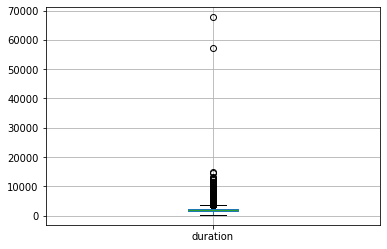

In [31]:
df['duration']=df['end']-df['start']
df.boxplot('duration')

In [33]:
df.sort_values('duration', ascending=False)

,start,end,transcription,eaf_source,wav_source,raw_transcription,clip,wav_rawpath,file_name,path,...,nist_stnr,speaker-diarization-3.1,voice-activity-detection,whisper-large-v3,clapipa-transcription-allosaurus,vad_s,drz_s,trans_len,pcnt_speech,duration
4423,1061966.0,1129675.0,jígíɲàt̪ɔ́ ðɔ́mɔ̀cà ðɔ̀ndà,/Users/markjos/Library/CloudStorage/GoogleDriv...,/Users/markjos/Library/CloudStorage/GoogleDriv...,jígíɲàt̪ɔ́ ðɔ́mɔ̀tʃà ðɔ̀ndà,data/tira-asr/clips/HH20211108-m17s41ms966-m18...,/Users/markjos/Library/CloudStorage/GoogleDriv...,data/tira-asr/clips/HH20211108-m17s41ms966-m18...,HH20211108-m17s41ms966-m18s49ms675.wav,...,26.75,0.031 3.018 SPEAKER_00; 7.726 10.510 SPEAKER_0...,0.166 1.955 SPEECH;2.393 2.984 SPEECH;7.760 9....,Iginyato lomocha zonda. Iginyato lomocha zond...,0.5370,34.998,26.510,31,0.516888,67709.0
2689,2666782.0,2724008.0,lídí,/Users/markjos/Library/CloudStorage/GoogleDriv...,/Users/markjos/Library/CloudStorage/GoogleDriv...,lídí,data/tira-asr/clips/HH09172020-m44s26ms782-m45...,/Users/markjos/Library/CloudStorage/GoogleDriv...,data/tira-asr/clips/HH09172020-m44s26ms782-m45...,HH09172020-m44s26ms782-m45s24ms008.wav,...,54.25,0.031 0.588 SPEAKER_00; 5.600 6.427 SPEAKER_00...,0.065 0.588 SPEECH;5.633 6.443 SPEECH;7.777 8....,"Lady. Okay. That was cool. All right, let me ...",0.3585,22.021,22.663,6,0.384808,57226.0
10327,2636103.0,2650863.0,t̪ál və̀lɛ̀ðɔ́ édɔ̀ɽɔ̀,/Users/markjos/Library/CloudStorage/GoogleDriv...,/Users/markjos/Library/CloudStorage/GoogleDriv...,* t̪ál` və̀lɛ̀ðɔ́ édɔ̀ɽɔ̀,data/tira-asr/clips/HH20220708-2-m43s56ms103-m...,/Users/markjos/Library/CloudStorage/GoogleDriv...,data/tira-asr/clips/HH20220708-2-m43s56ms103-m...,HH20220708-2-m43s56ms103-m44s10ms863.wav,...,28.00,0.233 1.280 SPEAKER_00; 2.208 2.579 SPEAKER_00...,0.284 1.280 SPEECH;2.242 2.579 SPEECH;3.085 4....,"Well, it could be... No, you need to say some...",-0.0357,6.346,6.800,24,0.429946,14760.0
20530,807376.0,821846.0,án óndè kɛðəŋnɔl àprí ano kárlɛ̀ɲì ŋinɛ,/Users/markjos/Library/CloudStorage/GoogleDriv...,/Users/markjos/Library/CloudStorage/GoogleDriv...,án óndè kɛðəŋnɔl àprí ano kárlɛ̀ɲì ŋinɛ,data/tira-asr/clips/HH12092020-m13s27ms376-m13...,/Users/markjos/Library/CloudStorage/GoogleDriv...,data/tira-asr/clips/HH12092020-m13s27ms376-m13...,HH12092020-m13s27ms376-m13s41ms846.wav,...,30.00,0.031 1.634 SPEAKER_00; 2.073 3.305 SPEAKER_00...,0.233 1.550 SPEECH;2.258 3.018 SPEECH;3.507 4....,ለለለለለለለለለለለለለለለለለለለለለለለለለለለለለለለለለለለለለለለለለለለለለ...,0.6943,7.612,9.231,46,0.526054,14470.0
10753,2612367.0,2625654.0,ðàvə́lɛ̂ðɛ̀ ðàŋvə́lɛ̂ðɛ̀,/Users/markjos/Library/CloudStorage/GoogleDriv...,/Users/markjos/Library/CloudStorage/GoogleDriv...,ðàvə́lɛ̂ːðɛ̀ -- ðàŋvə́lɛ̂ːðɛ̀,data/tira-asr/clips/HH02122021-m43s32ms367-m43...,/Users/markjos/Library/CloudStorage/GoogleDriv...,data/tira-asr/clips/HH02122021-m43s32ms367-m43...,HH02122021-m43s32ms367-m43s45ms654.wav,...,34.00,2.039 2.393 SPEAKER_00; 3.878 7.068 SPEAKER_00...,0.200 1.297 SPEECH;1.550 2.377 SPEECH;3.878 7....,is it possible to say so it pulled it meaning...,0.6151,7.711,8.859,26,0.580342,13287.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
22910,61930.0,62190.0,bû,/Users/markjos/Library/CloudStorage/GoogleDriv...,/Users/markjos/Library/CloudStorage/GoogleDriv...,bû,data/tira-asr/clips/HH20211011-m01s01ms930-m01...,/Users/markjos/Library/CloudStorage/GoogleDriv...,data/tira-asr/clips/HH20211011-m01s01ms930-m01...,HH20211011-m01s01ms930-m01s02ms190.wav,...,4.00,0.031 0.385 SPEAKER_00,0.031 0.284 SPEECH,Boa.,0.5301,0.253,0.354,3,0.973077,260.0
22823,2842915.0,2843174.0,ðáwà,/Users/markjos/Library/CloudStorage/GoogleDriv...,/Users/markjos/Library/CloudStorage/GoogleDriv...,ðáwà,data/tira-asr/clips/HH20220805-1-m47s22ms915-m...,/Users/markjos/Library/CloudStorage/GoogleDriv...,data/tira-asr/clips/HH20220805-1-m47s22ms915-m...,HH20220805-1-m47s22ms915-m47s23ms174.wav,...,2.00,0.031 0.368 SPEAKER_00,0.031 0.284 SPEECH,that way.,-